In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from catenets.models.jax import TNet, SNet1,SNet2,DRNet,RNet
import pandas as pd
from sklearn.metrics import mean_squared_error

class SmallMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out.squeeze(-1)

def generate_data(
    N=10000, 
    d=10,
    K=3,             # number of treatments
    p=0.0,           # correlation parameter for w2 = p w1 + ...
    c=1.0,           # scaling for w1, w2
    confounding_level=1.0,
    seed=42
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Generate features X
    X = np.random.normal(0, 1, size=(N, d))
    
    # Generate orthonormal vectors u1, u2 in R^5
    u1 = np.random.normal(0, 1, size=5)
    u2 = np.random.normal(0, 1, size=5)
    u1 = u1 / np.linalg.norm(u1)
    u2 = u2 - (u2@u1)*u1
    u2 = u2 / np.linalg.norm(u2)
    
    # Build weight vectors w1, w2
    w1 = c * u1
    w2 = c * (p*u1 + np.sqrt(max(1-p**2, 0))*u2)
    
    # Treatment assignment
    beta_0 = np.random.normal(0, 0.1, size=K)
    beta_k = np.random.normal(0, 1.0, size=(K,d))
    
    # Calculate logits
    alpha_list = []
    for k in range(K):
        alpha_kx = beta_0[k] + confounding_level * X.dot(beta_k[k])
        alpha_list.append(alpha_kx)
    alpha_np = np.vstack(alpha_list).T
    
    # Softmax for treatment probabilities
    def softmax(z):
        z_shift = z - np.max(z, axis=1, keepdims=True)
        expz = np.exp(z_shift)
        return expz / np.sum(expz, axis=1, keepdims=True)
    
    probs_np = softmax(alpha_np)
    T = np.array([np.random.choice(K, p=probs_np[i]) for i in range(N)])
    
    # Generate non-linear components using MLPs
    mlp1 = SmallMLP(d)
    mlp2 = SmallMLP(d)
    
    X_torch = torch.FloatTensor(X)
    psi1_vals = mlp1(X_torch).detach().numpy()
    psi2_vals = mlp2(X_torch).detach().numpy()
    
    # Outcome equations parameters
    gamma_0 = np.random.normal(1, 0.5, size=2)
    gamma_m = np.random.normal(1, 1.0, size=(2,d))
    alpha_m0 = np.random.normal(1, 1.5, size=2)
    delta_mT = np.random.normal(0, 0.5, size=(2,K))
    alpha_mT = np.random.normal(0, 0.3, size=(2,K))
    
    # Generate outcomes
    Y = np.zeros((N,2))
    
    for i in range(N):
        x_i = X[i]
        t_i = T[i]
        x_15 = x_i[:5]
        
        # Outcome 1
        B1 = gamma_0[0] + confounding_level*(gamma_m[0].dot(x_i)) + alpha_m0[0]*(w1.dot(x_15))
        E1 = delta_mT[0, t_i] + alpha_mT[0, t_i]*(w1.dot(x_15)) + psi1_vals[i]
        mu1 = B1 + E1
        
        # Outcome 2
        B2 = gamma_0[1] + confounding_level*(gamma_m[1].dot(x_i)) + alpha_m0[1]*(w2.dot(x_15))
        E2 = delta_mT[1, t_i] + alpha_mT[1, t_i]*(w2.dot(x_15)) + psi2_vals[i]
        mu2 = B2 + E2
        
        eps1 = np.random.normal(0, 0.1)
        eps2 = np.random.normal(0, 0.1)
        
        Y[i,0] = mu1 + eps1
        Y[i,1] = mu2 + eps2
    
    return X, T, Y, w1, w2, delta_mT, alpha_mT, gamma_m, gamma_0, alpha_m0, psi1_vals, psi2_vals

ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.20.1.
Please upgrade numpy to >= 1.20.3 to use this pandas version

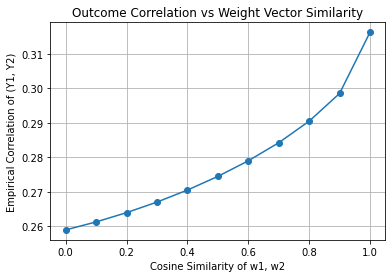

In [22]:
def experiment_correlation_vs_cosine():
    p_values = np.linspace(0, 1, 11)
    corrs = []
    cosines = []
    
    for p in p_values:
        X, T, Y, w1, w2, delta_mT, alpha_mT, gamma_m, gamma_0, alpha_m0, psi1_vals, psi2_vals = generate_data(N=3000, p=p, c=2.0, confounding_level=2, seed=42)
        
        # Calculate outcome correlation
        corr_mat = np.corrcoef(Y[:,0], Y[:,1])
        y_corr = corr_mat[0,1]
        
        # Calculate weight vector cosine similarity
        dot_w1w2 = w1.dot(w2)
        norm_w1 = np.linalg.norm(w1)
        norm_w2 = np.linalg.norm(w2)
        cos_sim = dot_w1w2 / (norm_w1*norm_w2)
        
        corrs.append(y_corr)
        cosines.append(cos_sim)
    
    # Plot results
    plt.figure(figsize=(6,4))
    plt.plot(cosines, corrs, marker='o')
    plt.xlabel("Cosine Similarity of w1, w2")
    plt.ylabel("Empirical Correlation of (Y1, Y2)")
    plt.title("Outcome Correlation vs Weight Vector Similarity")
    plt.grid(True)
    plt.show()

experiment_correlation_vs_cosine()

In [11]:
def prepare_data_for_cate(X, T, Y, train_size=8000):
    """Convert raw data into DataFrame format with train/test split"""
    data = pd.DataFrame(
        data=X,
        columns=[f'x{i}' for i in range(X.shape[1])]
    )
    data['T'] = T
    
    train_data = data.iloc[:train_size]
    train_label = [Y[:train_size, 0], Y[:train_size, 1]]
    test_data = data.iloc[train_size:]
    test_label = [Y[train_size:, 0], Y[train_size:, 1]]
    
    return train_data, train_label, test_data, test_label

def calculate_true_cate(x_i, t_i, delta_mT, alpha_mT, w1, w2):
    """Calculate true CATE for a single instance"""
    x_15 = x_i[:5]
    
    # Calculate treatment effects for each treatment
    cate_y0 = []
    cate_y1 = []
    
    for k in range(len(delta_mT[0])):
        effect_y0 = delta_mT[0, k] + alpha_mT[0, k]*(w1.dot(x_15))
        effect_y1 = delta_mT[1, k] + alpha_mT[1, k]*(w2.dot(x_15))
        cate_y0.append(effect_y0)
        cate_y1.append(effect_y1)
    
    return np.array(cate_y0), np.array(cate_y1)

def evaluate_cate(p, seed, learner_cls):
    """
    Evaluates CATE predictions using a specified learner.
    """
    # Generate data
    X, T, Y, w1, w2, delta_mT, alpha_mT, gamma_m, gamma_0, alpha_m0, psi1_vals, psi2_vals = generate_data(
        p=p, seed=seed, K=2
    )
    print(T)
    
    # Prepare data
    train_data, train_label, test_data, test_label = prepare_data_for_cate(X, T, Y)

    # Calculate true CATEs for test set
    X_test = test_data.iloc[:, :-1].values
    true_cates_y0 = []
    true_cates_y1 = []
    
    for i in range(len(X_test)):
        cate_y0, cate_y1 = calculate_true_cate(X_test[i], T[i], delta_mT, alpha_mT, w1, w2)
        true_cates_y0.append(cate_y0[1] - cate_y0[0])  # Effect of treatment 1 vs 0
        true_cates_y1.append(cate_y1[1] - cate_y1[0])

    # Prepare features and labels for training
    X_train = train_data.iloc[:, :-1].values
    A_train = train_data['T'].values
    Y_train = train_label[0]
    C_train = train_label[1]

    # Train and evaluate models
    if learner_cls.__name__ == 'SLearner':
        model_y = learner_cls(n_unit_in=10, binary_y=False)
        model_c = learner_cls(n_unit_in=10, binary_y=False)
    else:
        model_y = learner_cls(binary_y=False)
        model_c = learner_cls(binary_y=False)

    # Fit and predict
    model_y.fit(X=X_train, y=Y_train, w=A_train)
    model_c.fit(X=X_train, y=C_train, w=A_train)
    
    cate_pred_y = model_y.predict(X_test)
    cate_pred_c = model_c.predict(X_test)

    # Convert predictions if using SLearner
    if learner_cls.__name__ == 'SLearner':
        cate_pred_y = cate_pred_y.cpu().detach().numpy()
        cate_pred_c = cate_pred_c.cpu().detach().numpy()

    # Calculate RMSE
    rmse_y = np.sqrt(mean_squared_error(true_cates_y0, cate_pred_y))
    rmse_c = np.sqrt(mean_squared_error(true_cates_y1, cate_pred_c))

    print(f"RMSE for treatment effect by t_Y: {rmse_y:.4f}")
    print(f"RMSE for treatment effect by t_C: {rmse_c:.4f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(true_cates_y0, cate_pred_y, alpha=0.5)
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE ($t_Y$)')
    plt.title('True vs Predicted CATE (Model $t_Y$)')
    
    plt.subplot(1, 2, 2)
    plt.scatter(true_cates_y1, cate_pred_c, alpha=0.5)
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE ($t_C$)')
    plt.title('True vs Predicted CATE (Model $t_C$)')
    
    plt.tight_layout()
    plt.show()
    
    return rmse_y, rmse_c


[1 1 1 ... 1 0 0]
RMSE for treatment effect by t_Y: 0.3973
RMSE for treatment effect by t_C: 0.2174


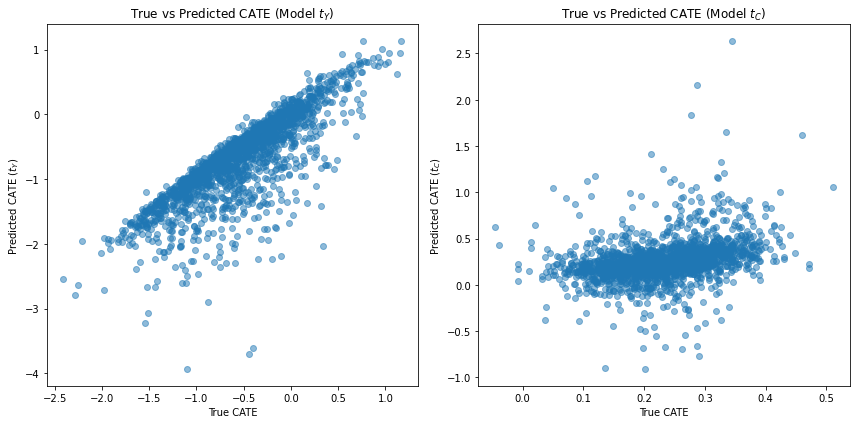

(0.3973063598444564, 0.21738008532958883)

In [24]:
evaluate_cate(p=0.5, seed=123, learner_cls=TNet)

[1 1 1 ... 1 0 0]
RMSE for treatment effect by t_Y: 0.2261
RMSE for treatment effect by t_C: 0.1162


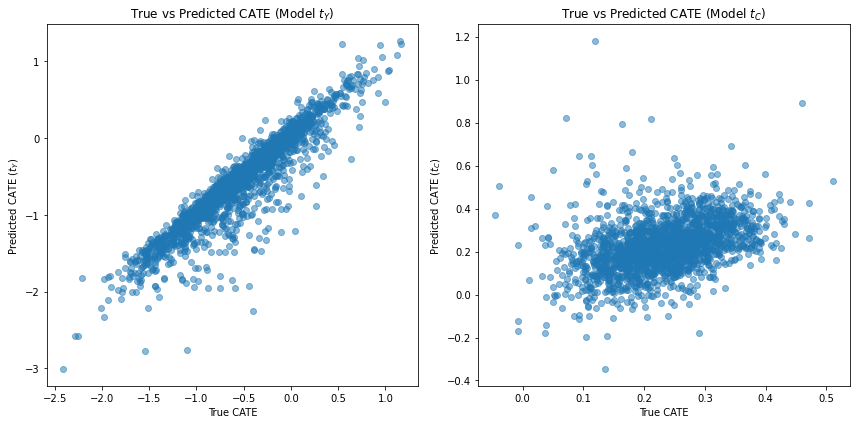

(0.22610434129553125, 0.11620211468110431)

In [25]:
evaluate_cate(p=0.5, seed=123, learner_cls=SNet1)

[1 1 1 ... 1 0 0]
RMSE for treatment effect by t_Y: 0.3094
RMSE for treatment effect by t_C: 0.2005


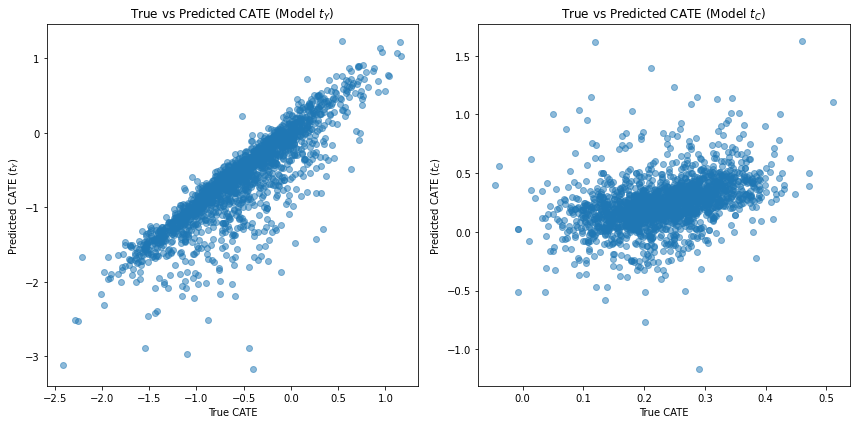

(0.30936611697051514, 0.20045506462009763)

In [26]:
evaluate_cate(p=0.5, seed=123, learner_cls=SNet2)

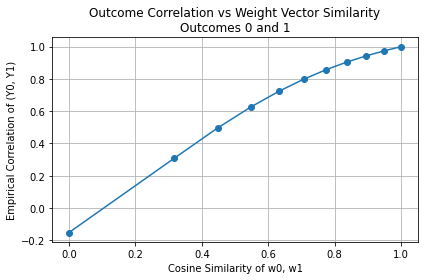

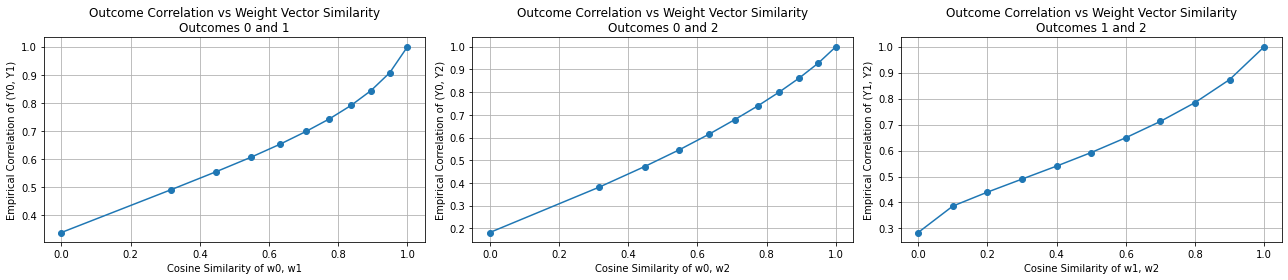

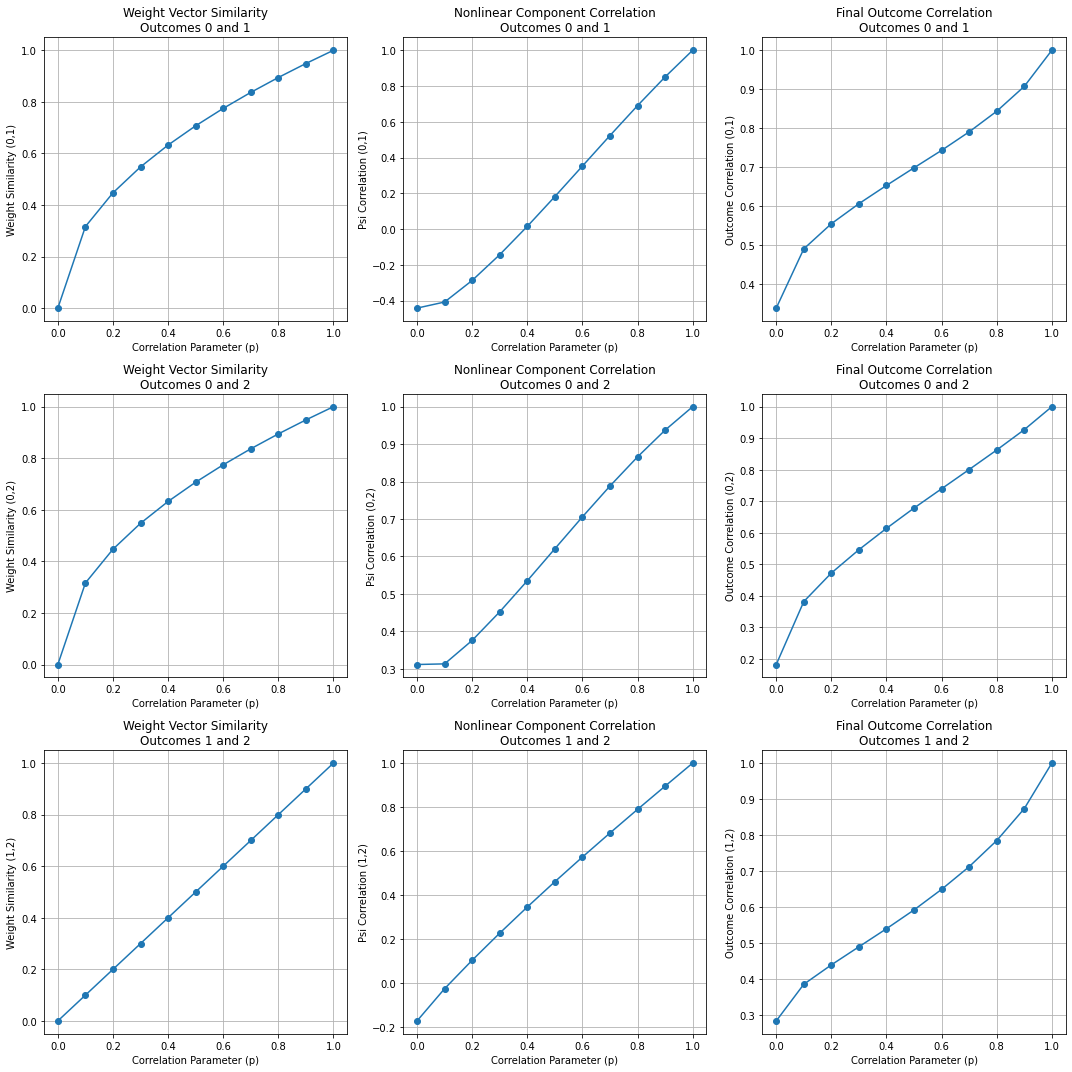

Running original experiment...


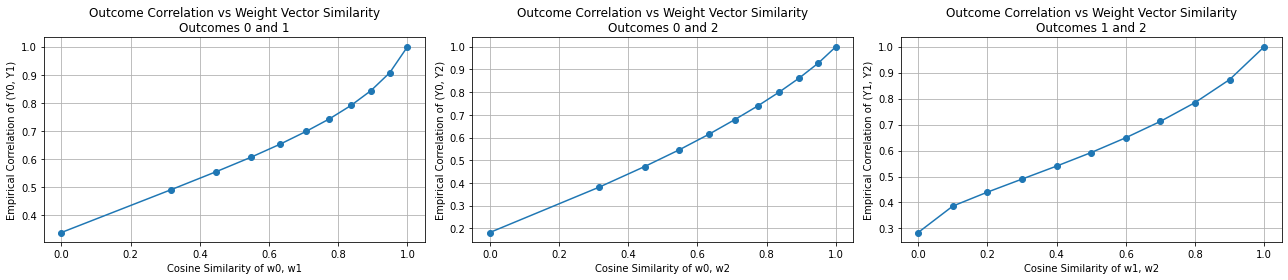


Analyzing component correlations...


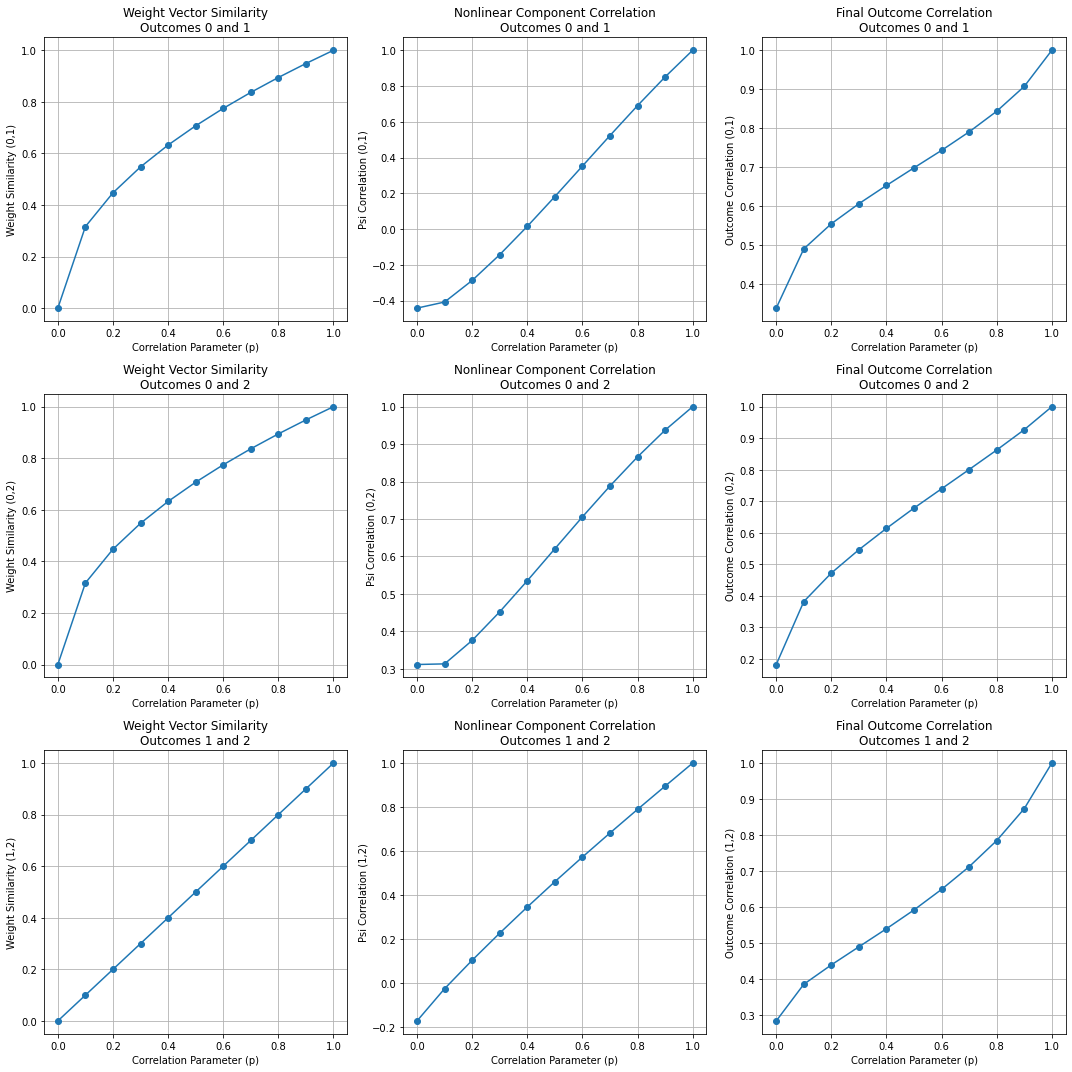


Generating high correlation example (p=0.8)...

Outcome correlation matrix:
[[1.         0.84744108 0.86960448]
 [0.84744108 1.         0.79314976]
 [0.86960448 0.79314976 1.        ]]

Nonlinear component correlation matrix:
[[1.         0.69036151 0.86590401]
 [0.69036151 1.         0.78933147]
 [0.86590401 0.78933147 1.        ]]

Weight vector similarities:
Similarity between w0 and w1: 0.894
Similarity between w0 and w2: 0.894
Similarity between w1 and w2: 0.800


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

############################
# 1. Data Generation Components
############################

def softmax(x, axis=-1):
    """Compute softmax values for each set of scores in x."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class SmallMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out.squeeze(-1)

def generate_data(
    N=10000, 
    d=10,
    K=3,             # number of treatments
    M=2,             # number of outcomes
    p=0.0,           # correlation parameter between outcomes
    c=1.0,           # scaling for outcome weights
    confounding_level=3.0,
    noise_correlation=0.0,  # correlation in outcome noise
    seed=42
):
    """
    Generates synthetic data for multi-treatment, multi-outcome scenarios.
    
    Parameters:
    -----------
    N : int
        Number of samples
    d : int
        Dimension of features
    K : int
        Number of treatments
    M : int
        Number of outcomes
    p : float
        Base correlation parameter between outcomes
    c : float
        Scaling for outcome weights
    confounding_level : float
        Strength of confounding
    noise_correlation : float
        Base correlation coefficient between noise terms
    seed : int
        Random seed
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # (1) Generate features X
    X = np.random.normal(0, 1, size=(N, d))
    
    # (2) Generate orthonormal basis vectors
    basis_vectors = []
    v1 = np.random.normal(0, 1, size=5)
    v1 = v1 / np.linalg.norm(v1)
    basis_vectors.append(v1)
    
    # Generate second vector with controlled correlation
    for m in range(1, M):
        # Generate random vector
        v = np.random.normal(0, 1, size=5)
        # Make it orthogonal to all previous vectors
        for u in basis_vectors:
            v = v - (v @ u) * u
        v = v / np.linalg.norm(v)
        basis_vectors.append(v)
    
    # (3) Build weight vectors with proper correlation structure
    weights = np.zeros((M, 5))
    for m in range(M):
        if m == 0:
            weights[m] = c * basis_vectors[0]
        else:
            # Mix with first vector according to correlation parameter
            weights[m] = c * (np.sqrt(1-p) * basis_vectors[m] + np.sqrt(p) * basis_vectors[0])
            weights[m] = weights[m] / np.linalg.norm(weights[m])
    
    # (4) Treatment assignment parameters
    beta_0 = np.random.normal(0, 0.1, size=K)
    beta_k = np.random.normal(0, 1.0, size=(K,d))
    
    # (5-6) Calculate treatment probabilities (same as before)
    alpha_list = []
    for k in range(K):
        alpha_kx = beta_0[k] + confounding_level * X.dot(beta_k[k])
        alpha_list.append(alpha_kx)
    alpha_np = np.vstack(alpha_list).T
    
    probs_np = softmax(alpha_np)
    T = np.array([np.random.choice(K, p=probs_np[i]) for i in range(N)])
    
    # (7) Nonlinear components (MLPs) with correlation structure
    base_mlp = SmallMLP(d)
    mlps = [SmallMLP(d) for _ in range(M)]
    X_torch = torch.FloatTensor(X)
    
    # Generate correlated nonlinear components
    base_psi = base_mlp(X_torch).detach().numpy()
    psi_vals = []
    for m in range(M):
        indiv_psi = mlps[m](X_torch).detach().numpy()
        # Mix individual and shared nonlinear components
        psi_m = np.sqrt(1-p) * indiv_psi + np.sqrt(p) * base_psi
        psi_vals.append(psi_m)
    psi_vals = np.stack(psi_vals, axis=1)
    
    # (8) Outcome equations with correlated treatment effects
    gamma_0 = np.zeros(M)
    gamma_m = np.zeros((M, d))
    alpha_m0 = np.zeros(M)
    
    # Generate correlated parameters for each outcome
    for m in range(M):
        if m == 0:
            gamma_0[m] = np.random.normal(1, 0.5)
            gamma_m[m] = np.random.normal(1, 1.0, size=d)
            alpha_m0[m] = np.random.normal(1, 1.5)
        else:
            # Mix with base parameters according to correlation parameter
            gamma_0[m] = np.sqrt(1-p) * np.random.normal(1, 0.5) + np.sqrt(p) * gamma_0[0]
            gamma_m[m] = np.sqrt(1-p) * np.random.normal(1, 1.0, size=d) + np.sqrt(p) * gamma_m[0]
            alpha_m0[m] = np.sqrt(1-p) * np.random.normal(1, 1.5) + np.sqrt(p) * alpha_m0[0]
    
    # Generate correlated treatment effects
    base_delta = np.random.normal(0, 0.5, size=K)
    base_alpha = np.random.normal(0, 0.3, size=K)
    
    delta_mT = np.zeros((M, K))
    alpha_mT = np.zeros((M, K))
    
    for m in range(M):
        if m == 0:
            delta_mT[m] = base_delta
            alpha_mT[m] = base_alpha
        else:
            # Mix with base effects according to correlation parameter
            delta_mT[m] = np.sqrt(1-p) * np.random.normal(0, 0.5, size=K) + np.sqrt(p) * base_delta
            alpha_mT[m] = np.sqrt(1-p) * np.random.normal(0, 0.3, size=K) + np.sqrt(p) * base_alpha
    
    # (9) Construct final outcomes Y
    Y = np.zeros((N, M))
    
    # Generate correlated noise matrix for all samples at once
    noise_cov = np.ones((M, M)) * p  # Use same correlation parameter p
    np.fill_diagonal(noise_cov, 1)
    noise_cov *= 0.1  # Scale noise
    eps = np.random.multivariate_normal(np.zeros(M), noise_cov, size=N)
    
    for i in range(N):
        x_i = X[i]
        t_i = T[i]
        x_15 = x_i[:5]
        
        # Generate correlated components
        base_effect = weights[0].dot(x_15)  # Use first weight vector as base
        
        for m in range(M):
            # Calculate individual effect for all outcomes
            indiv_effect = weights[m].dot(x_15)
            # Mix with base effect according to correlation parameter
            mixed_effect = base_effect if m == 0 else np.sqrt(1-p)*indiv_effect + np.sqrt(p)*base_effect
            
            # Baseline effect with controlled correlation
            B_m = gamma_0[m] + confounding_level*(gamma_m[m].dot(x_i)) + alpha_m0[m]*mixed_effect
            
            # Treatment effect with controlled correlation
            E_m = delta_mT[m, t_i] + alpha_mT[m, t_i]*mixed_effect + psi_vals[i,m]
            
            Y[i, m] = B_m + E_m + eps[i,m]  # Add correlated noise
    
    return (X, T, Y, weights, delta_mT, alpha_mT, gamma_m, gamma_0, 
            alpha_m0, psi_vals)

def compute_true_effects(X, weights, delta_mT, alpha_mT, psi_vals, K, M):
    """
    Compute true treatment effects for each treatment and outcome.
    
    For multiple treatments and multiple outcomes:
    - CATE_km = E[Ym(k) - Ym(0)|X] for k = 1,...,K-1 and m = 0,...,M-1
    where Ym(k) is the potential outcome m under treatment k
    and Ym(0) is the potential outcome m under control
    
    Parameters:
    -----------
    X : array (N, d)
        Feature matrix
    weights : array (M, 5)
        Weight vectors for M outcomes
    delta_mT : array (M, K)
        Treatment main effects for each outcome and treatment
    alpha_mT : array (M, K)
        Treatment-covariate interactions for each outcome and treatment
    psi_vals : array (N, M)
        Nonlinear components for each outcome
    K : int
        Number of treatments
    M : int
        Number of outcomes
        
    Returns:
    --------
    true_cate : dict
        Dictionary containing true treatment effects:
        - f'outcome{m}': array (N, K-1) containing CATE for outcome m
        Each column k represents E[Ym(k+1) - Ym(0)|X]
    """
    N = X.shape[0]
    x_15 = X[:, :5]  # First 5 features used in treatment effects
    
    true_cate = {}
    
    # For each outcome m
    for m in range(M):
        # Initialize array to store CATEs (K-1 contrasts with control)
        cate_m = np.zeros((N, K-1))
        
        # Control treatment effect (k=0) for outcome m
        control_effect = delta_mT[m, 0] + alpha_mT[m, 0] * (x_15 @ weights[m])
        
        # Compute CATE for each treatment relative to control
        for k in range(1, K):  # Start from k=1, compare with control k=0
            # For outcome m: E[Ym(k) - Ym(0)|X]
            treatment_effect = delta_mT[m, k] + alpha_mT[m, k] * (x_15 @ weights[m])
            cate_m[:, k-1] = treatment_effect - control_effect
        
        true_cate[f'outcome{m}'] = cate_m  # Shape: (N, K-1)
    
    return true_cate

def generate_correlated_features(n_samples, n_features):
    """Generate features with complex correlation structure"""
    X = np.random.randn(n_samples, n_features)
    
    # Linear correlations
    X[:, 1] = 0.7 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 2] = -0.5 * X[:, 1] + 0.2 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    
    # Non-linear correlations
    X[:, 3] = np.sin(X[:, 0]) + 0.2 * X[:, 1]**2 + 0.3 * np.random.randn(n_samples)
    
    # Interaction-based correlation
    X[:, 4] = X[:, 0] * X[:, 1] + np.exp(X[:, 2] * 0.3) + 0.3 * np.random.randn(n_samples)
    
    # Normalize features
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X

def generate_scenario_A(confounding_level=0.0, outcome_correlation=0.5):
    """Binary T, Multiple O, No Conf"""
    n_samples = 10000
    n_features = 5
    
    # Generate features with complex correlations
    X = generate_correlated_features(n_samples, n_features)
    
    # Treatment assignment - random binary treatment
    T = np.random.binomial(1, 0.5, size=n_samples)
    
    # Generate correlated noise
    noise_cov = np.ones((3, 3)) * outcome_correlation
    np.fill_diagonal(noise_cov, 1)
    noise_cov *= 0.1  # Reduced noise scale
    noise = np.random.multivariate_normal(np.zeros(3), noise_cov, size=n_samples)
    
    # Define true treatment effects (CATE) first
    true_effects = {
        0: 3 * X[:, 0]**2 + X[:, 1] * X[:, 2],
        1: np.exp(X[:, 1]) + X[:, 0] * X[:, 4],
        2: X[:, 0] * X[:, 1] + np.sin(X[:, 3])
    }
    
    # Generate shared baseline effect (independent of treatment)
    shared_baseline = X[:, 0]**2 + np.sin(X[:, 1] * X[:, 2])
    shared_baseline = shared_baseline / np.std(shared_baseline)
    
    # Generate outcomes
    Y = np.zeros((n_samples, 3))
    
    for m in range(3):
        # Individual baseline (non-treatment) component
        if m == 0:
            baseline = 2 * X[:, 0]
        elif m == 1:
            baseline = np.sin(X[:, 3])
        else:
            baseline = X[:, 2] + X[:, 4]
            
        # Normalize baseline
        baseline = baseline / np.std(baseline)
        
        # Combine baseline effects with correlation structure
        total_baseline = (np.sqrt(1 - outcome_correlation) * baseline + 
                         np.sqrt(outcome_correlation) * shared_baseline)
        
        # Add treatment effect and noise
        Y[:, m] = total_baseline + T * true_effects[m] + noise[:, m]
    
    # True CATE
    true_cate = {
        'outcome0': np.column_stack([true_effects[0]]),
        'outcome1': np.column_stack([true_effects[1]]),
        'outcome2': np.column_stack([true_effects[2]])
    }
    
    return {'X': X, 'T': T, 'Y': Y, 'true_cate': true_cate}

def generate_scenario_B(confounding_level=0.0, outcome_correlation=0.0):
    """Multiple T, Single O, No Conf - Introducing treatment complexity"""
    n_samples = 10000
    n_features = 5
    n_treatments = 3
    
    # Generate features with complex correlations
    X = generate_correlated_features(n_samples, n_features)
    
    # Treatment assignment with controllable confounding
    propensity = softmax(confounding_level * np.column_stack([
        X[:, 0]**2 + X[:, 1] * X[:, 2],
        -X[:, 3] + np.sin(X[:, 4]),
        X[:, 2]**2 - X[:, 0] * X[:, 4]
    ]), axis=1)
    T = np.array([np.random.choice(n_treatments, p=p) for p in propensity])
    
    T_ind = np.zeros((n_samples, n_treatments))
    T_ind[np.arange(n_samples), T] = 1
    
    # Generate single outcome with treatment-specific effects
    Y = np.zeros((n_samples, 1))
    
    # Complex treatment-specific effects using multiple features
    Y[:, 0] = (np.sin(X[:, 0] + X[:, 3]) * T_ind[:, 0] + 
               (np.exp(X[:, 1]) + X[:, 2] * X[:, 4]) * T_ind[:, 1] + 
               (X[:, 0] * X[:, 1] + np.sin(X[:, 2] * X[:, 3])) * T_ind[:, 2] + 
               0.3 * np.random.randn(n_samples))
    
    # True CATE (relative to treatment 0)
    true_cate = {
        'outcome0': np.column_stack([
            (np.exp(X[:, 1]) + X[:, 2] * X[:, 4]) - np.sin(X[:, 0] + X[:, 3]),
            (X[:, 0] * X[:, 1] + np.sin(X[:, 2] * X[:, 3])) - np.sin(X[:, 0] + X[:, 3])
        ])
    }
    
    return {'X': X, 'T': T, 'Y': Y, 'true_cate': true_cate}

def generate_scenario_C(confounding_level=5.0, outcome_correlation=0.5):
    """Binary T, Multiple O, With Conf - Adding confounding"""
    n_samples = 10000
    n_features = 5
    
    # Generate features with complex correlations
    X = generate_correlated_features(n_samples, n_features)
    
    # Treatment assignment with controllable confounding
    propensity = 1 / (1 + np.exp(-confounding_level * (
        2 * X[:, 0]**2 - X[:, 1] * X[:, 2] + np.sin(X[:, 3]) + X[:, 4]
    )))
    T = np.random.binomial(1, propensity)
    
    # Generate correlated noise
    noise_cov = np.array([[1, outcome_correlation], 
                         [outcome_correlation, 1]]) * 0.25  # Increased noise impact
    noise = np.random.multivariate_normal(np.zeros(2), noise_cov, size=n_samples)
    
    # Treatment-dependent shared effect (more complex)
    shared_effect = (X[:, 0]**2 * T + 
                    np.sin(X[:, 1] * X[:, 2]) * (1-T) + 
                    np.exp(X[:, 3] * 0.5))
    
    # Normalize shared effect
    shared_effect = shared_effect / np.std(shared_effect)
    
    # Generate outcomes
    Y = np.zeros((n_samples, 2))
    
    # Individual effects for each outcome
    for m in range(2):
        # Individual effect (different for each outcome)
        if m == 0:
            individual_effect = (X[:, 0]**2 + X[:, 1] * X[:, 2] + 
                               T * (2 * X[:, 0] + np.sin(X[:, 3]) + X[:, 1] * X[:, 4]))
        else:
            individual_effect = (np.sin(X[:, 3]) + X[:, 0] * X[:, 4] + 
                               T * (np.exp(X[:, 0]) + X[:, 1] * X[:, 2] + np.sin(X[:, 3] * X[:, 4])))
        
        # Normalize individual effect
        individual_effect = individual_effect / np.std(individual_effect)
        
        # Combine effects with proper scaling
        Y[:, m] = (np.sqrt(1 - outcome_correlation) * individual_effect + 
                   np.sqrt(outcome_correlation) * shared_effect + 
                   0.2 * noise[:, m])  # Moderate noise scale
    
    # True CATE remains the same
    true_cate = {
        'outcome0': np.column_stack([2 * X[:, 0] + np.sin(X[:, 3]) + X[:, 1] * X[:, 4]]),
        'outcome1': np.column_stack([np.exp(X[:, 0]) + X[:, 1] * X[:, 2] + np.sin(X[:, 3] * X[:, 4])])
    }
    
    return {'X': X, 'T': T, 'Y': Y, 'true_cate': true_cate}

def generate_scenario_D(confounding_level=3.0, outcome_correlation=0.0):
    """Multiple T, Single O, With Conf - Multiple treatments with confounding"""
    n_samples = 10000
    n_features = 5
    n_treatments = 3
    
    # Generate features
    X = np.random.randn(n_samples, n_features)
    X[:, 1] = X[:, 0] * 0.4 + np.random.randn(n_samples) * 0.1
    X[:, 2] = np.sin(X[:, 0]) + np.random.randn(n_samples) * 0.1
    
    # Treatment assignment with controllable confounding
    propensity = softmax(confounding_level * np.column_stack([
        X[:, 0]**2 - X[:, 1],
        -X[:, 0] + np.sin(X[:, 1]),
        X[:, 2]**2 - X[:, 0] * X[:, 1]
    ]), axis=1)
    T = np.array([np.random.choice(n_treatments, p=p) for p in propensity])
    
    T_ind = np.zeros((n_samples, n_treatments))
    T_ind[np.arange(n_samples), T] = 1
    
    # Generate single outcome with complex treatment effects
    Y = np.zeros((n_samples, 1))
    
    Y[:, 0] = (2 * X[:, 0] * T_ind[:, 0] + 
               np.exp(X[:, 1]) * T_ind[:, 1] + 
               (X[:, 0] * X[:, 1]) * T_ind[:, 2] + 
               confounding_level * (X[:, 0]**2 + np.sin(X[:, 1])) +  # Confounding effects
               0.4 * np.random.randn(n_samples))
    
    # True CATE (relative to treatment 0)
    true_cate = {
        'outcome0': np.column_stack([
            np.exp(X[:, 1]) - 2 * X[:, 0],
            (X[:, 0] * X[:, 1]) - 2 * X[:, 0]
        ])
    }
    
    return {'X': X, 'T': T, 'Y': Y, 'true_cate': true_cate}

def generate_scenario_E(confounding_level=0.0, outcome_correlation=0.5):
    """Multiple T, Multiple O, No Conf - Adding outcome complexity"""
    n_samples = 10000
    n_features = 5
    n_treatments = 3
    
    # Generate features with complex correlations
    X = generate_correlated_features(n_samples, n_features)
    
    # Treatment assignment (no confounding)
    T = np.random.choice(n_treatments, size=n_samples)
    T_ind = np.zeros((n_samples, n_treatments))
    T_ind[np.arange(n_samples), T] = 1
    
    # Generate correlated noise
    noise_cov = np.ones((3, 3)) * outcome_correlation
    np.fill_diagonal(noise_cov, 1)
    noise_cov *= 0.25  # Increased noise impact
    noise = np.random.multivariate_normal(np.zeros(3), noise_cov, size=n_samples)
    
    # Treatment-dependent shared effect (more complex)
    shared_effect = (X[:, 0]**2 * T_ind[:, 0] + 
                    np.sin(X[:, 1] * X[:, 2]) * T_ind[:, 1] + 
                    np.exp(X[:, 3] * 0.5) * T_ind[:, 2])
    
    # Normalize shared effect
    shared_effect = shared_effect / np.std(shared_effect)
    
    # Generate outcomes
    Y = np.zeros((n_samples, 3))
    
    for m in range(3):
        # Individual effect (different for each outcome)
        individual_effect = np.zeros(n_samples)
        for t in range(n_treatments):
            if t == 0:
                effect = 2 * X[:, 0] + m * np.sin(X[:, 1])
            elif t == 1:
                effect = np.exp(X[:, 1]) + m * X[:, 2]**2
            else:
                effect = X[:, 0] * X[:, 1] + m * np.sin(X[:, 3])
            individual_effect += effect * T_ind[:, t]
        
        # Normalize individual effect
        individual_effect = individual_effect / np.std(individual_effect)
        
        # Combine effects with proper scaling
        Y[:, m] = (np.sqrt(1 - outcome_correlation) * individual_effect + 
                   np.sqrt(outcome_correlation) * shared_effect + 
                   0.2 * noise[:, m])  # Moderate noise scale
    
    # True CATE remains the same
    true_cate = {
        'outcome0': np.column_stack([
            np.exp(X[:, 1]) - 2 * X[:, 0],
            X[:, 0] * X[:, 1] - 2 * X[:, 0]
        ]),
        'outcome1': np.column_stack([
            np.exp(X[:, 1]) + X[:, 2]**2 - (2 * X[:, 0] + np.sin(X[:, 1])),
            X[:, 0] * X[:, 1] + np.sin(X[:, 3]) - (2 * X[:, 0] + np.sin(X[:, 1]))
        ]),
        'outcome2': np.column_stack([
            np.exp(X[:, 1]) + 2 * X[:, 2]**2 - (2 * X[:, 0] + 2 * np.sin(X[:, 1])),
            X[:, 0] * X[:, 1] + 2 * np.sin(X[:, 3]) - (2 * X[:, 0] + 2 * np.sin(X[:, 1]))
        ])
    }
    
    return {'X': X, 'T': T, 'Y': Y, 'true_cate': true_cate}

def generate_scenario_F(confounding_level=5.0, outcome_correlation=0.5, num_treatments=4, num_outcomes=3):
    """Multiple T, Multiple O, With Conf - Most complex scenario"""
    n_samples = 10000
    n_features = 5
    
    # Generate features with complex correlations
    X = generate_correlated_features(n_samples, n_features)
    
    # Treatment assignment with controllable confounding
    treatment_logits = []
    for t in range(num_treatments):
        if t == 0:
            logit = 2 * X[:, 0]**2 - X[:, 1]
        elif t == 1:
            logit = -X[:, 0] + 2 * np.sin(X[:, 1])
        elif t == 2:
            logit = X[:, 2]**2 - X[:, 0] * X[:, 1]
        else:
            logit = X[:, 0] * X[:, 2] - np.sin(X[:, 1])
        treatment_logits.append(confounding_level * logit)
    
    propensity = softmax(np.column_stack(treatment_logits), axis=1)
    T = np.array([np.random.choice(num_treatments, p=p) for p in propensity])
    T_ind = np.zeros((n_samples, num_treatments))
    T_ind[np.arange(n_samples), T] = 1
    
    # Generate correlated noise
    noise_cov = np.ones((num_outcomes, num_outcomes)) * outcome_correlation
    np.fill_diagonal(noise_cov, 1)
    noise_cov *= 0.25  # Increased noise impact
    noise = np.random.multivariate_normal(np.zeros(num_outcomes), noise_cov, size=n_samples)
    
    # Treatment-dependent shared effect (more complex)
    shared_effect = X[:, 0]**2 * T_ind[:, 0]  # Base effect
    for t in range(1, num_treatments):
        if t == 1:
            effect = np.sin(X[:, 1] * X[:, 2])
        elif t == 2:
            effect = np.exp(X[:, 3] * 0.5)
        else:
            effect = X[:, 0] * X[:, 4]
        shared_effect += effect * T_ind[:, t]
    
    # Normalize shared effect
    shared_effect = shared_effect / np.std(shared_effect)
    
    # Generate outcomes
    Y = np.zeros((n_samples, num_outcomes))
    
    for m in range(num_outcomes):
        # Individual effect (different for each outcome)
        individual_effect = np.zeros(n_samples)
        for t in range(num_treatments):
            if t == 0:
                effect = 2 * X[:, 0] + m * np.sin(X[:, 1])  # Different per outcome
            elif t == 1:
                effect = 3 * np.sin(X[:, 1]) + m * X[:, 2]**2
            elif t == 2:
                effect = -2 * X[:, 2]**2 + m * np.exp(X[:, 0])
            else:
                effect = np.exp(X[:, 0]) + m * np.sin(X[:, 3])
            individual_effect += effect * T_ind[:, t]
        
        # Normalize individual effect
        individual_effect = individual_effect / np.std(individual_effect)
        
        # Combine effects with proper scaling
        Y[:, m] = (np.sqrt(1 - outcome_correlation) * individual_effect + 
                   np.sqrt(outcome_correlation) * shared_effect + 
                   0.2 * noise[:, m])  # Moderate noise scale
    
    # True CATE (relative to treatment 0)
    true_cate = {}
    for m in range(num_outcomes):
        cate_matrix = []
        for t in range(1, num_treatments):
            if t == 1:
                cate = (3 * np.sin(X[:, 1]) + m * X[:, 2]**2) - (2 * X[:, 0] + m * np.sin(X[:, 1]))
            elif t == 2:
                cate = (-2 * X[:, 2]**2 + m * np.exp(X[:, 0])) - (2 * X[:, 0] + m * np.sin(X[:, 1]))
            else:
                cate = (np.exp(X[:, 0]) + m * np.sin(X[:, 3])) - (2 * X[:, 0] + m * np.sin(X[:, 1]))
            cate_matrix.append(cate)
        true_cate[f'outcome{m}'] = np.column_stack(cate_matrix)
    
    return {'X': X, 'T': T, 'Y': Y, 'true_cate': true_cate}

def generate_scenario_data(scenario, N=10000, d=10, num_outcomes=2, num_treatments=3, 
                         confounding_level=5.0, outcome_correlation=0.5, seed=42):
    """
    Generate synthetic data for one of six scenarios (A-F).
    
    Parameters:
    -----------
    scenario : str
        One of 'A', 'B', 'C', 'D', 'E', 'F'
    N : int
        Number of samples
    d : int
        Number of features
    num_outcomes : int
        Number of outcomes
    num_treatments : int
        Number of treatments
    confounding_level : float
        Strength of confounding (0 = no confounding, higher = stronger confounding)
    outcome_correlation : float
        Correlation between outcomes (0 = independent, 1 = perfectly correlated)
    """
    print(f"Generating scenario {scenario} with confounding level {confounding_level} and outcome correlation {outcome_correlation}")
    # Define scenario-specific parameters
    scenario_params = {
        'A': generate_scenario_A,  # Baseline scenario, no parameters
        'B': lambda: generate_scenario_B(
            confounding_level=0.0,  # No confounding in scenario B
            outcome_correlation=0.0  # Single outcome, no correlation needed
        ),
        'C': lambda: generate_scenario_C(
            confounding_level=confounding_level,
            outcome_correlation=outcome_correlation
        ),
        'D': lambda: generate_scenario_D(
            confounding_level=confounding_level,
            outcome_correlation=0.0  # Single outcome
        ),
        'E': lambda: generate_scenario_E(
            confounding_level=0.0,  # No confounding
            outcome_correlation=outcome_correlation
        ),
        'F': lambda: generate_scenario_F(
            confounding_level=confounding_level,
            outcome_correlation=outcome_correlation,
            num_treatments=num_treatments,
            num_outcomes=num_outcomes
        )
    }
    
    if scenario not in scenario_params:
        raise ValueError(f"Scenario must be one of {list(scenario_params.keys())}")
    
    # Set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Generate data using scenario-specific function
    data = scenario_params[scenario]()
    
    # Add metadata
    data['metadata'] = {
        'scenario': scenario,
        'N': N,
        'd': d,
        'num_outcomes': num_outcomes,
        'num_treatments': num_treatments,
        'seed': seed,
        'confounding_level': confounding_level,
        'outcome_correlation': outcome_correlation
    }
    
    return data

def generate_all_scenarios(N=10000, d=10, num_outcomes=2, num_treatments=3,
                         confounding_level=5.0, outcome_correlation=0.1, base_seed=42):
    """Generate data for all six scenarios."""
    scenarios = {}
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        # Override num_treatments for specific scenarios
        if scenario == 'A' or scenario == 'C':
            scenario_treatments = 2  # Binary treatment
        else:
            scenario_treatments = num_treatments  # Default (3) for all multi-treatment scenarios
            
        scenarios[scenario] = generate_scenario_data(
            scenario=scenario,
            N=N,
            d=d,
            num_outcomes=num_outcomes,
            num_treatments=scenario_treatments,  # Use scenario-specific number
            confounding_level=confounding_level,
            outcome_correlation=outcome_correlation,
            seed=base_seed + ord(scenario) - ord('A')
        )
    return scenarios

def experiment_correlation_vs_cosine(M=2):
    """
    Experiment to analyze relationship between outcome correlation and weight vector similarity
    for multiple outcomes.
    
    Parameters:
    -----------
    M : int
        Number of outcomes to analyze
    """
    p_values = np.linspace(0, 1, 11)
    # Store correlations and cosine similarities for each pair of outcomes
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    results = {(i,j): {'corrs': [], 'cosines': []} for i,j in outcome_pairs}
    
    for p in p_values:
        # Generate data with current correlation parameter
        X, T, Y, weights, *_ = generate_data(N=3000, p=p, c=2.0, M=M, confounding_level=2, seed=42)
        
        # Calculate correlations and cosine similarities for each pair
        for i, j in outcome_pairs:
            # Calculate outcome correlation
            corr_mat = np.corrcoef(Y[:,i], Y[:,j])
            y_corr = corr_mat[0,1]
            
            # Calculate weight vector cosine similarity
            w_i = weights[i]
            w_j = weights[j]
            dot_wij = w_i.dot(w_j)
            norm_wi = np.linalg.norm(w_i)
            norm_wj = np.linalg.norm(w_j)
            cos_sim = dot_wij / (norm_wi*norm_wj)
            
            results[(i,j)]['corrs'].append(y_corr)
            results[(i,j)]['cosines'].append(cos_sim)
    
    # Plot results
    plt.figure(figsize=(6*len(outcome_pairs), 4))
    for idx, (i,j) in enumerate(outcome_pairs, 1):
        plt.subplot(1, len(outcome_pairs), idx)
        plt.plot(results[(i,j)]['cosines'], results[(i,j)]['corrs'], marker='o')
        plt.xlabel(f"Cosine Similarity of w{i}, w{j}")
        plt.ylabel(f"Empirical Correlation of (Y{i}, Y{j})")
        plt.title(f"Outcome Correlation vs Weight Vector Similarity\nOutcomes {i} and {j}")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test with 2 outcomes (should reproduce original behavior)
experiment_correlation_vs_cosine(M=2)

# Test with 3 outcomes (will show relationships between all pairs)
experiment_correlation_vs_cosine(M=3)

def analyze_correlation_impact(M=3, N=10000, correlation_levels=None):
    """
    Analyze how outcome correlation affects estimation accuracy.
    
    Parameters:
    -----------
    M : int
        Number of outcomes
    N : int
        Number of samples
    correlation_levels : list, optional
        List of correlation levels to test
    """
    if correlation_levels is None:
        correlation_levels = np.linspace(0, 0.9, 10)
    
    # Store results
    mse_results = {f'outcome{m}': [] for m in range(M)}
    
    for corr in correlation_levels:
        # Generate data with current correlation
        data = generate_scenario_A(outcome_correlation=corr)
        X, T, Y = data['X'], data['T'], data['Y']
        true_cate = data['true_cate']
        
        # Calculate MSE between outcomes and their expected values
        for m in range(M):
            # True CATE for this outcome
            true_effect = true_cate[f'outcome{m}'][:, 0]
            
            # Calculate empirical treatment effect
            treated_idx = T == 1
            control_idx = T == 0
            
            emp_treated = Y[treated_idx, m].mean()
            emp_control = Y[control_idx, m].mean()
            emp_effect = emp_treated - emp_control
            
            # Calculate MSE
            mse = np.mean((true_effect - emp_effect)**2)
            mse_results[f'outcome{m}'].append(mse)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    for m in range(M):
        plt.plot(correlation_levels, mse_results[f'outcome{m}'], 
                marker='o', label=f'Outcome {m}')
    
    plt.xlabel('Outcome Correlation')
    plt.ylabel('Mean Squared Error')
    plt.title('Impact of Outcome Correlation on Estimation Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return mse_results

def analyze_component_correlations(M=2, N=3000):
    """
    Analyze correlations in different components (weights, nonlinear terms, final outcomes)
    as the correlation parameter changes.
    """
    p_values = np.linspace(0, 1, 11)
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    
    # Store results for different components
    results = {(i,j): {
        'weight_sims': [], 
        'psi_corrs': [], 
        'outcome_corrs': []
    } for i,j in outcome_pairs}
    
    for p in p_values:
        # Generate data
        X, T, Y, weights, *_, psi_vals = generate_data(
            N=N, p=p, c=2.0, M=M, confounding_level=2, seed=42)
        
        # Calculate correlations for each pair
        for i, j in outcome_pairs:
            # Weight vector similarity
            w_i, w_j = weights[i], weights[j]
            weight_sim = w_i.dot(w_j) / (np.linalg.norm(w_i) * np.linalg.norm(w_j))
            
            # Nonlinear component correlation
            psi_corr = np.corrcoef(psi_vals[:,i], psi_vals[:,j])[0,1]
            
            # Final outcome correlation
            outcome_corr = np.corrcoef(Y[:,i], Y[:,j])[0,1]
            
            results[(i,j)]['weight_sims'].append(weight_sim)
            results[(i,j)]['psi_corrs'].append(psi_corr)
            results[(i,j)]['outcome_corrs'].append(outcome_corr)
    
    # Plot results
    plt.figure(figsize=(15, 5*len(outcome_pairs)))
    for idx, (i,j) in enumerate(outcome_pairs):
        # Weight similarities
        plt.subplot(len(outcome_pairs), 3, 3*idx + 1)
        plt.plot(p_values, results[(i,j)]['weight_sims'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Weight Similarity ({i},{j})')
        plt.title(f'Weight Vector Similarity\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Nonlinear correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 2)
        plt.plot(p_values, results[(i,j)]['psi_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Psi Correlation ({i},{j})')
        plt.title(f'Nonlinear Component Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Outcome correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 3)
        plt.plot(p_values, results[(i,j)]['outcome_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Outcome Correlation ({i},{j})')
        plt.title(f'Final Outcome Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Test the analysis
analyze_component_correlations(M=3)

if __name__ == "__main__":
    # Run original experiment to see cosine similarity vs empirical correlation
    print("Running original experiment...")
    experiment_correlation_vs_cosine(M=3)
    
    # Run component analysis to verify correlation structure
    print("\nAnalyzing component correlations...")
    analyze_component_correlations(M=3)
    
    # Generate and analyze a single dataset with high correlation
    print("\nGenerating high correlation example (p=0.8)...")
    X, T, Y, weights, *_, psi_vals = generate_data(N=3000, p=0.8, M=3, seed=42)
    N=N, p=p, c=2.0, M=M, confounding_level=2, seed=42
    
    # Print correlation matrices
    print("\nOutcome correlation matrix:")
    print(np.corrcoef(Y.T))
    
    print("\nNonlinear component correlation matrix:")
    print(np.corrcoef(psi_vals.T))
    
    # Calculate weight vector similarities
    print("\nWeight vector similarities:")
    for i in range(3):
        for j in range(i+1, 3):
            sim = weights[i].dot(weights[j]) / (np.linalg.norm(weights[i]) * np.linalg.norm(weights[j]))
            print(f"Similarity between w{i} and w{j}: {sim:.3f}")

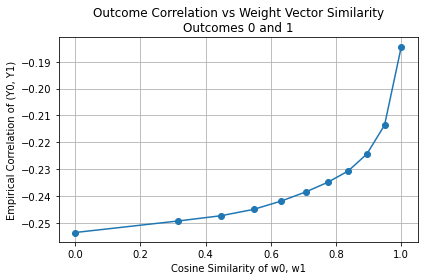

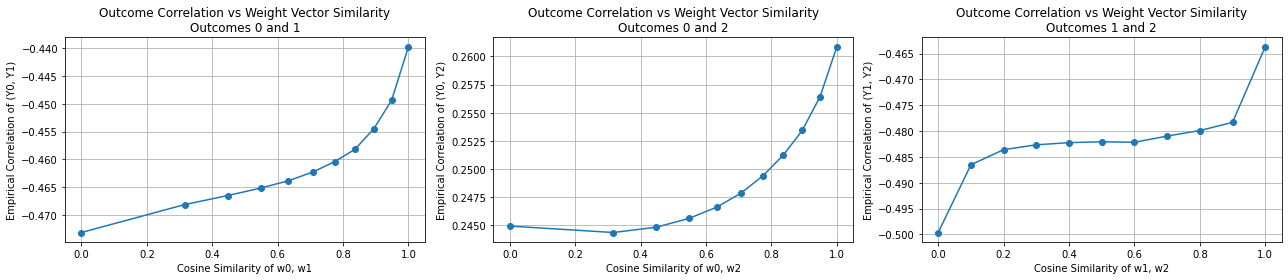

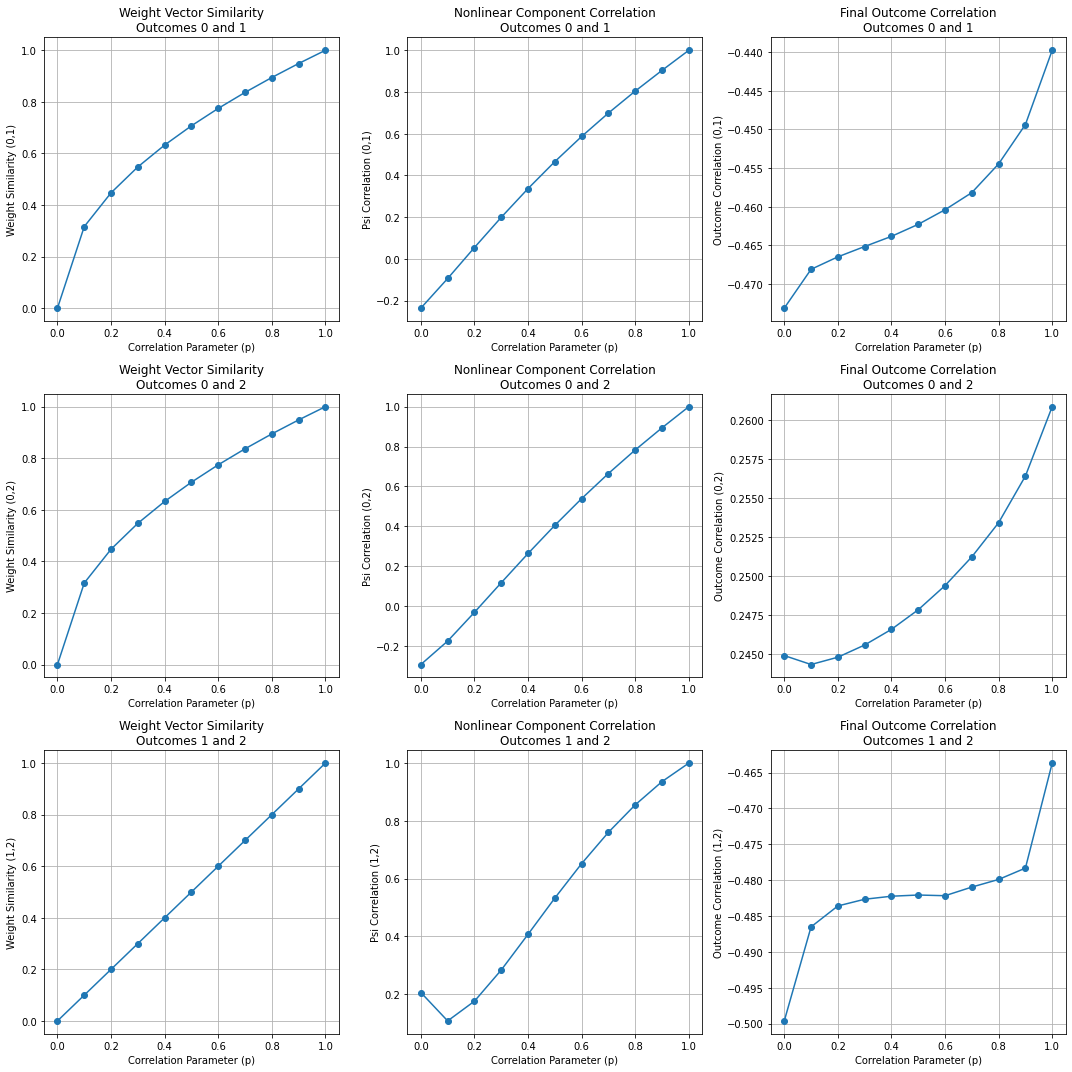

Running original experiment...


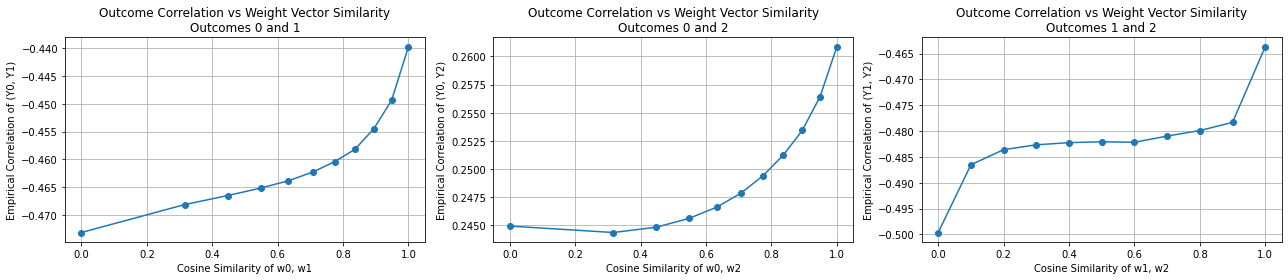


Analyzing component correlations...


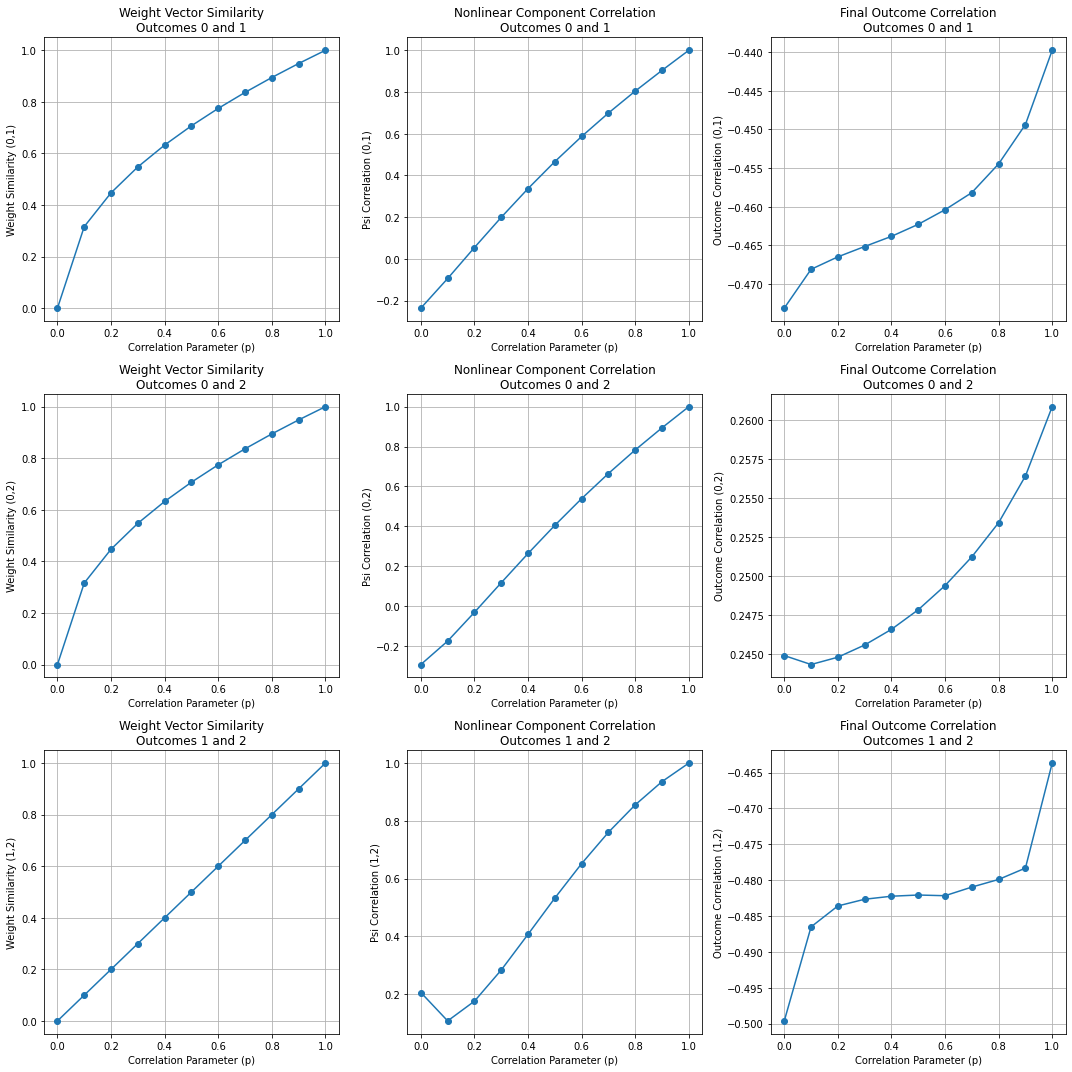


Generating high correlation example (p=0.8)...

Outcome correlation matrix:
[[ 1.         -0.45445383  0.25343617]
 [-0.45445383  1.         -0.47989921]
 [ 0.25343617 -0.47989921  1.        ]]

Nonlinear component correlation matrix:
[[1.         0.80432995 0.78285478]
 [0.80432995 1.         0.85548432]
 [0.78285478 0.85548432 1.        ]]

Weight vector similarities:
Similarity between w0 and w0: 1.000
Similarity between w0 and w1: 0.894
Similarity between w0 and w2: 0.894
Similarity between w1 and w1: 1.000
Similarity between w1 and w2: 0.800
Similarity between w2 and w2: 1.000


In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

############################
# 1. Data Generation Components
############################

def softmax(x, axis=-1):
    """Compute softmax values for each set of scores in x."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class SmallMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out.squeeze(-1)

def generate_correlated_features(n_samples, n_features):
    """Generate features with complex correlation structure"""
    X = np.random.randn(n_samples, n_features)
    
    # First 5 features - strong correlations
    X[:, 1] = 0.7 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 2] = -0.5 * X[:, 1] + 0.2 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 3] = np.sin(X[:, 0]) + 0.2 * X[:, 1]**2 + 0.3 * np.random.randn(n_samples)
    X[:, 4] = X[:, 0] * X[:, 1] + np.exp(X[:, 2] * 0.3) + 0.3 * np.random.randn(n_samples)
    
    # Additional features (5-9) - weaker correlations
    if n_features > 5:
        X[:, 5] = 0.3 * X[:, 0] + 0.2 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 6] = np.cos(X[:, 1]) + 0.1 * X[:, 3] + 0.5 * np.random.randn(n_samples)
        X[:, 7] = 0.4 * X[:, 2] - 0.2 * X[:, 5] + 0.5 * np.random.randn(n_samples)
        X[:, 8] = np.sin(X[:, 6]) + 0.3 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 9] = 0.25 * X[:, 7] + 0.25 * X[:, 8] + 0.5 * np.random.randn(n_samples)
    
    # Normalize features
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X

def generate_data(
    N=10000, 
    d=10,
    num_treatments=3,
    num_outcomes=2,
    confounding_level=3.0,
    outcome_correlation=0.1,
    scenario='D',
    seed=42
):
    """
    Data generation process motivated by realistic scenarios:
    1. Outcomes can be correlated (common in healthcare, economics)
    2. Treatment effects vary by subgroups (heterogeneous treatment effects)
    3. Both linear and nonlinear relationships (common in real data)
    4. Confounding effects (typical in observational studies)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Generate features with realistic correlation structure
    X = generate_correlated_features(N, d)
    
    # Treatment assignment with confounding
    beta_0 = np.random.normal(0, 0.1, size=num_treatments)
    beta_k = np.random.normal(0, 1.0, size=(num_treatments, d))
    
    alpha_list = []
    for k in range(num_treatments):
        # Realistic confounding: treatment assignment depends on covariates
        alpha_k = beta_0[k] + confounding_level * X.dot(beta_k[k])
        alpha_list.append(alpha_k)
    alpha_np = np.vstack(alpha_list).T
    propensity = softmax(alpha_np, axis=1)
    T = np.array([np.random.choice(num_treatments, p=p) for p in propensity])
    T_ind = np.zeros((N, num_treatments))
    T_ind[np.arange(N), T] = 1
    
    # Generate orthonormal basis vectors for outcome correlation
    # (Common in multi-outcome studies where outcomes share underlying factors)
    basis_vectors = []
    v1 = np.random.normal(0, 1, size=5)
    v1 = v1 / np.linalg.norm(v1)
    basis_vectors.append(v1)
    
    for m in range(1, num_outcomes):
        v = np.random.normal(0, 1, size=5)
        for u in basis_vectors:
            v = v - (v @ u) * u
        v = v / np.linalg.norm(v)
        basis_vectors.append(v)
    
    # Generate weight vectors with correlation structure
    weights = np.zeros((num_outcomes, 5))
    for m in range(num_outcomes):
        if m == 0:
            weights[m] = 2.0 * basis_vectors[0]
        else:
            weights[m] = 2.0 * (np.sqrt(1-outcome_correlation) * basis_vectors[m] + 
                               np.sqrt(outcome_correlation) * basis_vectors[0])
    
    # Generate outcomes
    Y = np.zeros((N, num_outcomes))
    true_cate = {f'outcome{m}': np.zeros((N, num_treatments-1)) for m in range(num_outcomes)}
    all_psi_values = np.zeros((N, num_outcomes))
    
    # Create shared base MLP for nonlinear effects
    base_mlp = SmallMLP(input_dim=d)
    
    for m in range(num_outcomes):
        # Generate parameters
        gamma_0 = np.random.normal(0, 0.1)  # Intercept
        gamma_m = np.random.normal(0, 0.5, size=d)  # Linear effects
        delta_m = np.random.normal(0, 0.3, size=num_treatments)  # Treatment main effects
        
        # Calculate baseline effects (mix of linear and nonlinear)
        x_5 = X[:, :5]
        w_effect = weights[m].dot(x_5.T)  # Linear combination for interpretability
        B_m = (gamma_0 + 
               X.dot(gamma_m) +  # Linear component
               0.5 * np.sin(2 * w_effect))  # Nonlinear component
        
        # Calculate treatment effects
        E_m = np.zeros(N)
        for t in range(num_treatments):
            # Generate correlated nonlinear effects
            base_effect = base_mlp(torch.FloatTensor(X)).detach().numpy()
            mlp = SmallMLP(input_dim=d)
            specific_effect = mlp(torch.FloatTensor(X)).detach().numpy()
            
            # Combine base and specific effects with correlation structure
            psi_mt = 0.3 * (
                np.sqrt(outcome_correlation) * base_effect +
                np.sqrt(1 - outcome_correlation) * specific_effect
            )
            
            if t == 0:
                all_psi_values[:, m] = psi_mt
            
            # Complete treatment effect
            treatment_effect = (
                delta_m[t] +  # Main effect
                0.2 * X.dot(gamma_m) +  # Linear heterogeneity
                psi_mt +  # Correlated nonlinear heterogeneity
                0.1 * w_effect  # Interaction with baseline
            )
            
            E_m += T_ind[:, t] * treatment_effect
        
        # Generate outcome with realistic noise level
        Y[:, m] = B_m + E_m + 0.1 * np.random.randn(N)
        
        # Calculate true CATE
        for t in range(1, num_treatments):
            mlp_t = SmallMLP(input_dim=d)
            psi_t = 0.3 * mlp_t(torch.FloatTensor(X)).detach().numpy()
            mlp_0 = SmallMLP(input_dim=d)
            psi_0 = 0.3 * mlp_0(torch.FloatTensor(X)).detach().numpy()
            
            true_cate[f'outcome{m}'][:, t-1] = (
                (delta_m[t] - delta_m[0]) +  # Difference in main effects
                0.2 * X.dot(gamma_m) +  # Linear heterogeneity
                (psi_t - psi_0) +  # Nonlinear heterogeneity
                0.1 * w_effect  # Baseline interaction
            )
    
    return {
        'X': X,
        'T': T,
        'Y': Y,
        'true_cate': true_cate,
        'weights': weights,
        'psi_vals': all_psi_values
    }

def generate_all_scenarios(N=10000, d=10, num_outcomes=3, num_treatments=3,
                         confounding_level=5.0, outcome_correlation=0.5, base_seed=42):
    """Generate data for all six scenarios."""
    scenarios = {}
    
    # Define parameter modifications for each scenario
    scenario_params = {
        'A': dict(num_treatments=2, confounding_level=0.0),  # Binary T, Multiple O, No Conf
        'B': dict(num_outcomes=1, confounding_level=0.0),    # Multiple T, Single O, No Conf
        'C': dict(num_treatments=2),                         # Binary T, Multiple O, With Conf
        'D': dict(num_outcomes=1),                          # Multiple T, Single O, With Conf
        'E': dict(confounding_level=0.0),                   # Multiple T, Multiple O, No Conf
        'F': dict()                                         # Multiple T, Multiple O, With Conf
    }
    
    # Generate data for each scenario
    base_params = {
        'N': N,
        'd': d,
        'num_treatments': num_treatments,
        'num_outcomes': num_outcomes,
        'confounding_level': confounding_level,
        'outcome_correlation': outcome_correlation
    }
    
    for scenario, override_params in scenario_params.items():
        # Create scenario-specific parameters by updating base parameters
        scenario_params = base_params.copy()
        scenario_params.update(override_params)
        scenario_params['scenario'] = scenario
        scenario_params['seed'] = base_seed + ord(scenario) - ord('A')
        
        scenarios[scenario] = generate_data(**scenario_params)
    
    return scenarios

def experiment_correlation_vs_cosine(M=2):
    """
    Experiment to analyze relationship between outcome correlation and weight vector similarity
    for multiple outcomes.
    """
    p_values = np.linspace(0, 1, 11)
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    results = {(i,j): {'corrs': [], 'cosines': []} for i,j in outcome_pairs}
    
    for p in p_values:
        # Generate data with current correlation parameter
        data = generate_data(N=3000, outcome_correlation=p, num_outcomes=M, confounding_level=2, seed=42)
        X, T, Y = data['X'], data['T'], data['Y']
        
        # Calculate correlations and cosine similarities for each pair
        for i, j in outcome_pairs:
            # Calculate outcome correlation
            corr_mat = np.corrcoef(Y[:,i], Y[:,j])
            y_corr = corr_mat[0,1]
            
            # Calculate weight vector cosine similarity
            w_i = data['weights'][i]
            w_j = data['weights'][j]
            dot_wij = w_i.dot(w_j)
            norm_wi = np.linalg.norm(w_i)
            norm_wj = np.linalg.norm(w_j)
            cos_sim = dot_wij / (norm_wi*norm_wj)
            
            results[(i,j)]['corrs'].append(y_corr)
            results[(i,j)]['cosines'].append(cos_sim)
    
    # Plot results
    plt.figure(figsize=(6*len(outcome_pairs), 4))
    for idx, (i,j) in enumerate(outcome_pairs, 1):
        plt.subplot(1, len(outcome_pairs), idx)
        plt.plot(results[(i,j)]['cosines'], results[(i,j)]['corrs'], marker='o')
        plt.xlabel(f"Cosine Similarity of w{i}, w{j}")
        plt.ylabel(f"Empirical Correlation of (Y{i}, Y{j})")
        plt.title(f"Outcome Correlation vs Weight Vector Similarity\nOutcomes {i} and {j}")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test with 2 outcomes (should reproduce original behavior)
experiment_correlation_vs_cosine(M=2)

# Test with 3 outcomes (will show relationships between all pairs)
experiment_correlation_vs_cosine(M=3)

def analyze_correlation_impact(M=3, N=10000, correlation_levels=None):
    """
    Analyze how outcome correlation affects estimation accuracy.
    
    Parameters:
    -----------
    M : int
        Number of outcomes
    N : int
        Number of samples
    correlation_levels : list, optional
        List of correlation levels to test
    """
    if correlation_levels is None:
        correlation_levels = np.linspace(0, 0.9, 10)
    
    # Store results
    mse_results = {f'outcome{m}': [] for m in range(M)}
    
    for corr in correlation_levels:
        # Generate data with current correlation
        data = generate_scenario_A(outcome_correlation=corr)
        X, T, Y = data['X'], data['T'], data['Y']
        true_cate = data['true_cate']
        
        # Calculate MSE between outcomes and their expected values
        for m in range(M):
            # True CATE for this outcome
            true_effect = true_cate[f'outcome{m}'][:, 0]
            
            # Calculate empirical treatment effect
            treated_idx = T == 1
            control_idx = T == 0
            
            emp_treated = Y[treated_idx, m].mean()
            emp_control = Y[control_idx, m].mean()
            emp_effect = emp_treated - emp_control
            
            # Calculate MSE
            mse = np.mean((true_effect - emp_effect)**2)
            mse_results[f'outcome{m}'].append(mse)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    for m in range(M):
        plt.plot(correlation_levels, mse_results[f'outcome{m}'], 
                marker='o', label=f'Outcome {m}')
    
    plt.xlabel('Outcome Correlation')
    plt.ylabel('Mean Squared Error')
    plt.title('Impact of Outcome Correlation on Estimation Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return mse_results

def analyze_component_correlations(M=2, N=3000):
    """
    Analyze correlations in different components (weights, nonlinear terms, final outcomes)
    as the correlation parameter changes.
    """
    p_values = np.linspace(0, 1, 11)
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    
    # Store results for different components
    results = {(i,j): {
        'weight_sims': [], 
        'psi_corrs': [], 
        'outcome_corrs': []
    } for i,j in outcome_pairs}
    
    for p in p_values:
        # Generate data
        data = generate_data(
            N=N, 
            outcome_correlation=p, 
            num_outcomes=M,
            confounding_level=2, 
            seed=42
        )
        X, T, Y = data['X'], data['T'], data['Y']
        
        # Calculate correlations for each pair
        for i, j in outcome_pairs:
            # Weight vector similarity
            w_i, w_j = data['weights'][i], data['weights'][j]
            weight_sim = w_i.dot(w_j) / (np.linalg.norm(w_i) * np.linalg.norm(w_j))
            
            # Nonlinear component correlation
            psi_corr = np.corrcoef(data['psi_vals'][:,i], data['psi_vals'][:,j])[0,1]
            
            # Final outcome correlation
            outcome_corr = np.corrcoef(Y[:,i], Y[:,j])[0,1]
            
            results[(i,j)]['weight_sims'].append(weight_sim)
            results[(i,j)]['psi_corrs'].append(psi_corr)
            results[(i,j)]['outcome_corrs'].append(outcome_corr)
    
    # Plot results
    plt.figure(figsize=(15, 5*len(outcome_pairs)))
    for idx, (i,j) in enumerate(outcome_pairs):
        # Weight similarities
        plt.subplot(len(outcome_pairs), 3, 3*idx + 1)
        plt.plot(p_values, results[(i,j)]['weight_sims'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Weight Similarity ({i},{j})')
        plt.title(f'Weight Vector Similarity\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Nonlinear correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 2)
        plt.plot(p_values, results[(i,j)]['psi_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Psi Correlation ({i},{j})')
        plt.title(f'Nonlinear Component Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Outcome correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 3)
        plt.plot(p_values, results[(i,j)]['outcome_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Outcome Correlation ({i},{j})')
        plt.title(f'Final Outcome Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Test the analysis
analyze_component_correlations(M=3)

if __name__ == "__main__":
    # Run original experiment to see cosine similarity vs empirical correlation
    print("Running original experiment...")
    experiment_correlation_vs_cosine(M=3)
    
    # Run component analysis to verify correlation structure
    print("\nAnalyzing component correlations...")
    analyze_component_correlations(M=3)
    
    # Generate and analyze a single dataset with high correlation
    print("\nGenerating high correlation example (p=0.8)...")
    data = generate_data(N=3000, outcome_correlation=0.8, num_outcomes=3, confounding_level=2, seed=42)
    
    X, T, Y, psi_vals = data['X'], data['T'], data['Y'],data['psi_vals']
    weights = data['weights']
    # Print correlation matrices
    print("\nOutcome correlation matrix:")
    print(np.corrcoef(Y.T))
    
    print("\nNonlinear component correlation matrix:")
    print(np.corrcoef(psi_vals.T))
    
    # Calculate weight vector similarities
    print("\nWeight vector similarities:")
    for i in range(3):
        for j in range(i, 3):
            sim = weights[i].dot(weights[j]) / (np.linalg.norm(weights[i]) * np.linalg.norm(weights[j]))
            print(f"Similarity between w{i} and w{j}: {sim:.3f}")

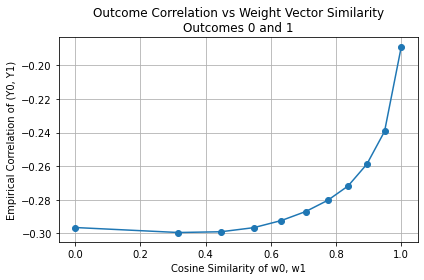

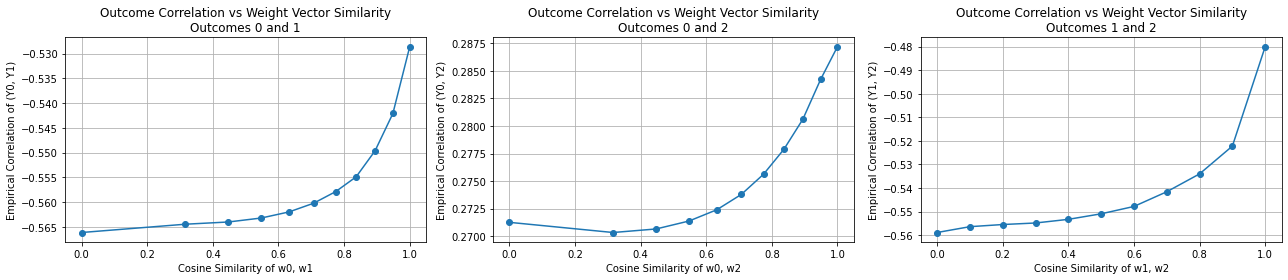

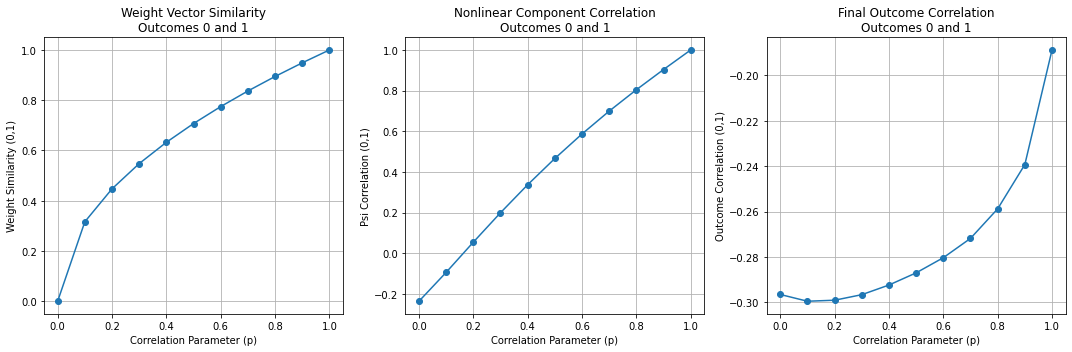

Running original experiment...


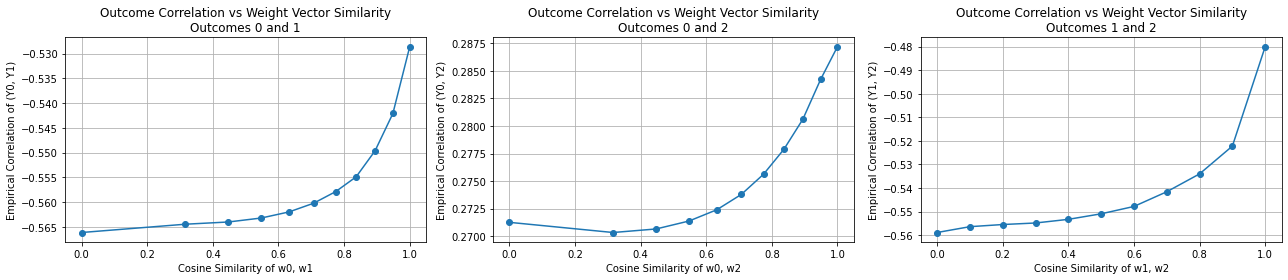


Analyzing component correlations...


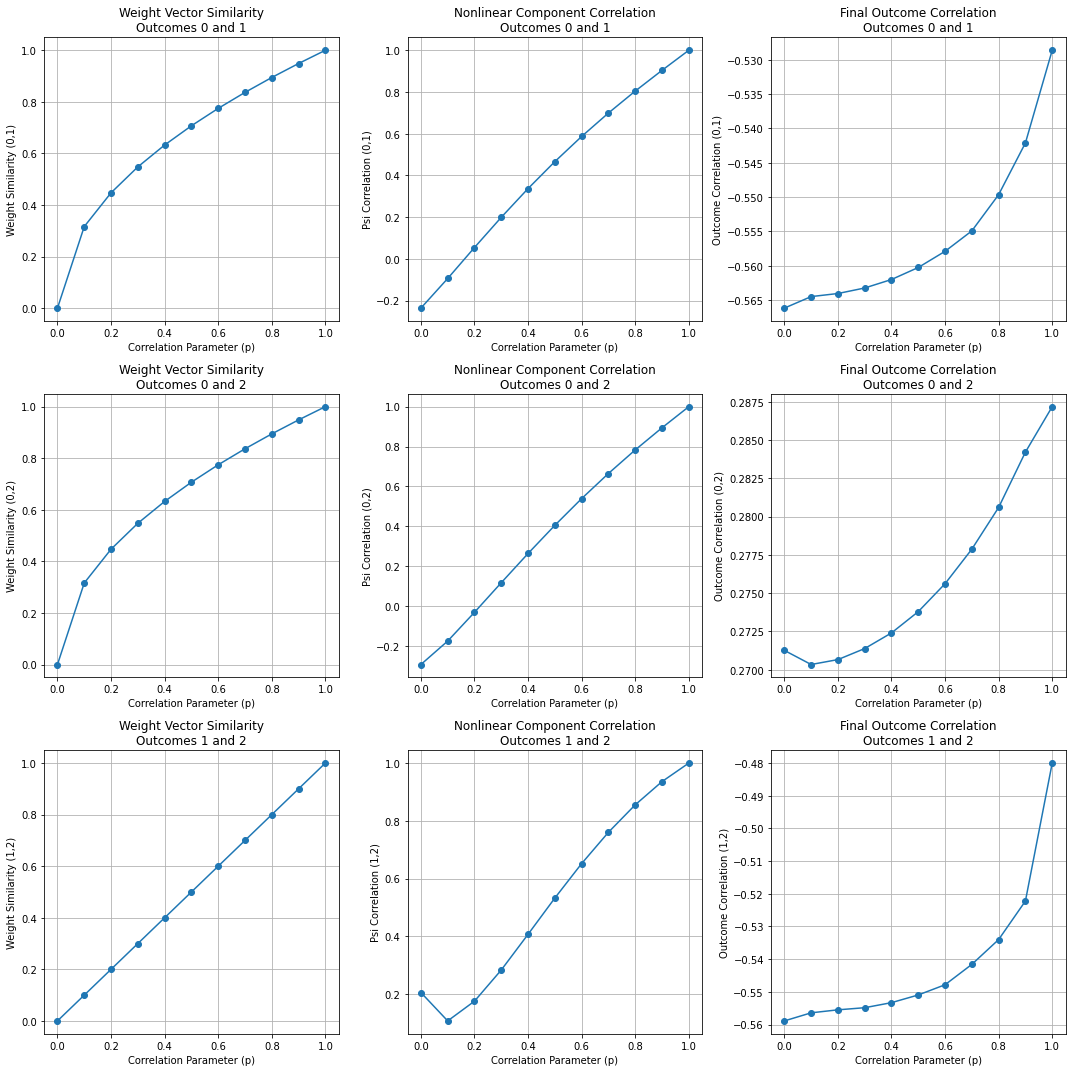


Generating high correlation example (p=0.8)...

Outcome correlation matrix:
[[ 1.         -0.54964263  0.28059962]
 [-0.54964263  1.         -0.53400759]
 [ 0.28059962 -0.53400759  1.        ]]

Nonlinear component correlation matrix:
[[1.         0.80432995 0.78285478]
 [0.80432995 1.         0.85548432]
 [0.78285478 0.85548432 1.        ]]

Weight vector similarities:
Similarity between w0 and w0: 1.000
Similarity between w0 and w1: 0.894
Similarity between w0 and w2: 0.894
Similarity between w1 and w1: 1.000
Similarity between w1 and w2: 0.800
Similarity between w2 and w2: 1.000


In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

############################
# 1. Data Generation Components
############################

def softmax(x, axis=-1):
    """Compute softmax values for each set of scores in x."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class SmallMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out.squeeze(-1)

def generate_correlated_features(n_samples, n_features):
    """Generate features with complex correlation structure"""
    X = np.random.randn(n_samples, n_features)
    
    # First 5 features - strong correlations
    X[:, 1] = 0.7 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 2] = -0.5 * X[:, 1] + 0.2 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 3] = np.sin(X[:, 0]) + 0.2 * X[:, 1]**2 + 0.3 * np.random.randn(n_samples)
    X[:, 4] = X[:, 0] * X[:, 1] + np.exp(X[:, 2] * 0.3) + 0.3 * np.random.randn(n_samples)
    
    # Additional features (5-9) - weaker correlations
    if n_features > 5:
        X[:, 5] = 0.3 * X[:, 0] + 0.2 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 6] = np.cos(X[:, 1]) + 0.1 * X[:, 3] + 0.5 * np.random.randn(n_samples)
        X[:, 7] = 0.4 * X[:, 2] - 0.2 * X[:, 5] + 0.5 * np.random.randn(n_samples)
        X[:, 8] = np.sin(X[:, 6]) + 0.3 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 9] = 0.25 * X[:, 7] + 0.25 * X[:, 8] + 0.5 * np.random.randn(n_samples)
    
    # Normalize features
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X

def generate_data(
    N=10000, 
    d=10,
    num_treatments=3,
    num_outcomes=2,
    confounding_level=3.0,
    outcome_correlation=0.1,
    prognostic_strength=5.0,  # New parameter to control baseline effect strength
    treatment_strength=0.5,   # New parameter to control treatment effect strength
    scenario='D',
    seed=42
):
    """
    Modified DGP with controllable prognostic and treatment effect strengths
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Generate features with realistic correlation structure
    X = generate_correlated_features(N, d)
    
    # Treatment assignment with confounding
    beta_0 = np.random.normal(0, 0.1, size=num_treatments)
    beta_k = np.random.normal(0, 1.0, size=(num_treatments, d))
    
    alpha_list = []
    for k in range(num_treatments):
        # Realistic confounding: treatment assignment depends on covariates
        alpha_k = beta_0[k] + confounding_level * X.dot(beta_k[k])
        alpha_list.append(alpha_k)
    alpha_np = np.vstack(alpha_list).T
    propensity = softmax(alpha_np, axis=1)
    T = np.array([np.random.choice(num_treatments, p=p) for p in propensity])
    T_ind = np.zeros((N, num_treatments))
    T_ind[np.arange(N), T] = 1
    
    # Generate orthonormal basis vectors for outcome correlation
    # (Common in multi-outcome studies where outcomes share underlying factors)
    basis_vectors = []
    v1 = np.random.normal(0, 1, size=5)
    v1 = v1 / np.linalg.norm(v1)
    basis_vectors.append(v1)
    
    for m in range(1, num_outcomes):
        v = np.random.normal(0, 1, size=5)
        for u in basis_vectors:
            v = v - (v @ u) * u
        v = v / np.linalg.norm(v)
        basis_vectors.append(v)
    
    # Generate weight vectors with correlation structure
    weights = np.zeros((num_outcomes, 5))
    for m in range(num_outcomes):
        if m == 0:
            weights[m] = 2.0 * basis_vectors[0]
        else:
            weights[m] = 2.0 * (np.sqrt(1-outcome_correlation) * basis_vectors[m] + 
                               np.sqrt(outcome_correlation) * basis_vectors[0])
    
    # Generate outcomes
    Y = np.zeros((N, num_outcomes))
    true_cate = {f'outcome{m}': np.zeros((N, num_treatments-1)) for m in range(num_outcomes)}
    all_psi_values = np.zeros((N, num_outcomes))
    
    # Create shared base MLP for nonlinear effects
    base_mlp = SmallMLP(input_dim=d)
    
    for m in range(num_outcomes):
        # Generate parameters
        gamma_0 = np.random.normal(0, 0.1)
        gamma_m = np.random.normal(0, 0.5, size=d)
        delta_m = np.random.normal(0, 0.3, size=num_treatments)
        
        # Calculate baseline effects (stronger prognostic effect)
        x_5 = X[:, :5]
        w_effect = weights[m].dot(x_5.T)
        B_m = prognostic_strength * (
            gamma_0 + 
            X.dot(gamma_m) +  # Linear component
            0.5 * np.sin(2 * w_effect)  # Nonlinear component
        )
        
        # Calculate treatment effects (relatively smaller)
        E_m = np.zeros(N)
        for t in range(num_treatments):
            base_effect = base_mlp(torch.FloatTensor(X)).detach().numpy()
            mlp = SmallMLP(input_dim=d)
            specific_effect = mlp(torch.FloatTensor(X)).detach().numpy()
            
            psi_mt = 0.3 * (
                np.sqrt(outcome_correlation) * base_effect +
                np.sqrt(1 - outcome_correlation) * specific_effect
            )
            
            if t == 0:
                all_psi_values[:, m] = psi_mt
            
            # Scaled down treatment effect
            treatment_effect = treatment_strength * (
                delta_m[t] +  
                0.2 * X.dot(gamma_m) +  
                psi_mt +  
                0.1 * w_effect
            )
            
            E_m += T_ind[:, t] * treatment_effect
        
        # Generate outcome
        Y[:, m] = B_m + E_m + 0.1 * np.random.randn(N)
        
        # Calculate true CATE
        for t in range(1, num_treatments):
            mlp_t = SmallMLP(input_dim=d)
            psi_t = 0.3 * mlp_t(torch.FloatTensor(X)).detach().numpy()
            mlp_0 = SmallMLP(input_dim=d)
            psi_0 = 0.3 * mlp_0(torch.FloatTensor(X)).detach().numpy()
            
            true_cate[f'outcome{m}'][:, t-1] = treatment_strength * (
                (delta_m[t] - delta_m[0]) +
                0.2 * X.dot(gamma_m) +
                (psi_t - psi_0) +
                0.1 * w_effect
            )
    
    return {
        'X': X,
        'T': T,
        'Y': Y,
        'true_cate': true_cate,
        'weights': weights,
        'psi_vals': all_psi_values
    }

def generate_all_scenarios(N=10000, d=10, num_outcomes=3, num_treatments=3,
                         confounding_level=5.0, outcome_correlation=0.5, base_seed=42):
    """Generate data for all six scenarios."""
    scenarios = {}
    
    # Define parameter modifications for each scenario
    scenario_params = {
        'A': dict(num_treatments=2, confounding_level=0.0),  # Binary T, Multiple O, No Conf
        'B': dict(num_outcomes=1, confounding_level=0.0),    # Multiple T, Single O, No Conf
        'C': dict(num_treatments=2),                         # Binary T, Multiple O, With Conf
        'D': dict(num_outcomes=1),                          # Multiple T, Single O, With Conf
        'E': dict(confounding_level=0.0),                   # Multiple T, Multiple O, No Conf
        'F': dict()                                         # Multiple T, Multiple O, With Conf
    }
    
    # Generate data for each scenario
    base_params = {
        'N': N,
        'd': d,
        'num_treatments': num_treatments,
        'num_outcomes': num_outcomes,
        'confounding_level': confounding_level,
        'outcome_correlation': outcome_correlation
    }
    
    for scenario, override_params in scenario_params.items():
        # Create scenario-specific parameters by updating base parameters
        scenario_params = base_params.copy()
        scenario_params.update(override_params)
        scenario_params['scenario'] = scenario
        scenario_params['seed'] = base_seed + ord(scenario) - ord('A')
        
        scenarios[scenario] = generate_data(**scenario_params)
    
    return scenarios

def experiment_correlation_vs_cosine(M=2):
    """
    Experiment to analyze relationship between outcome correlation and weight vector similarity
    for multiple outcomes.
    """
    p_values = np.linspace(0, 1, 11)
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    results = {(i,j): {'corrs': [], 'cosines': []} for i,j in outcome_pairs}
    
    for p in p_values:
        # Generate data with current correlation parameter
        data = generate_data(N=3000, outcome_correlation=p, num_outcomes=M, confounding_level=2, seed=42)
        X, T, Y = data['X'], data['T'], data['Y']
        
        # Calculate correlations and cosine similarities for each pair
        for i, j in outcome_pairs:
            # Calculate outcome correlation
            corr_mat = np.corrcoef(Y[:,i], Y[:,j])
            y_corr = corr_mat[0,1]
            
            # Calculate weight vector cosine similarity
            w_i = data['weights'][i]
            w_j = data['weights'][j]
            dot_wij = w_i.dot(w_j)
            norm_wi = np.linalg.norm(w_i)
            norm_wj = np.linalg.norm(w_j)
            cos_sim = dot_wij / (norm_wi*norm_wj)
            
            results[(i,j)]['corrs'].append(y_corr)
            results[(i,j)]['cosines'].append(cos_sim)
    
    # Plot results
    plt.figure(figsize=(6*len(outcome_pairs), 4))
    for idx, (i,j) in enumerate(outcome_pairs, 1):
        plt.subplot(1, len(outcome_pairs), idx)
        plt.plot(results[(i,j)]['cosines'], results[(i,j)]['corrs'], marker='o')
        plt.xlabel(f"Cosine Similarity of w{i}, w{j}")
        plt.ylabel(f"Empirical Correlation of (Y{i}, Y{j})")
        plt.title(f"Outcome Correlation vs Weight Vector Similarity\nOutcomes {i} and {j}")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test with 2 outcomes (should reproduce original behavior)
experiment_correlation_vs_cosine(M=2)

# Test with 3 outcomes (will show relationships between all pairs)
experiment_correlation_vs_cosine(M=3)

def analyze_correlation_impact(M=3, N=10000, correlation_levels=None):
    """
    Analyze how outcome correlation affects estimation accuracy.
    
    Parameters:
    -----------
    M : int
        Number of outcomes
    N : int
        Number of samples
    correlation_levels : list, optional
        List of correlation levels to test
    """
    if correlation_levels is None:
        correlation_levels = np.linspace(0, 0.9, 10)
    
    # Store results
    mse_results = {f'outcome{m}': [] for m in range(M)}
    
    for corr in correlation_levels:
        # Generate data with current correlation
        data = generate_scenario_A(outcome_correlation=corr)
        X, T, Y = data['X'], data['T'], data['Y']
        true_cate = data['true_cate']
        
        # Calculate MSE between outcomes and their expected values
        for m in range(M):
            # True CATE for this outcome
            true_effect = true_cate[f'outcome{m}'][:, 0]
            
            # Calculate empirical treatment effect
            treated_idx = T == 1
            control_idx = T == 0
            
            emp_treated = Y[treated_idx, m].mean()
            emp_control = Y[control_idx, m].mean()
            emp_effect = emp_treated - emp_control
            
            # Calculate MSE
            mse = np.mean((true_effect - emp_effect)**2)
            mse_results[f'outcome{m}'].append(mse)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    for m in range(M):
        plt.plot(correlation_levels, mse_results[f'outcome{m}'], 
                marker='o', label=f'Outcome {m}')
    
    plt.xlabel('Outcome Correlation')
    plt.ylabel('Mean Squared Error')
    plt.title('Impact of Outcome Correlation on Estimation Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return mse_results

def analyze_component_correlations(M=2, N=3000):
    """
    Analyze correlations in different components (weights, nonlinear terms, final outcomes)
    as the correlation parameter changes.
    """
    p_values = np.linspace(0, 1, 11)
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    
    # Store results for different components
    results = {(i,j): {
        'weight_sims': [], 
        'psi_corrs': [], 
        'outcome_corrs': []
    } for i,j in outcome_pairs}
    
    for p in p_values:
        # Generate data
        data = generate_data(
            N=N, 
            outcome_correlation=p, 
            num_outcomes=M,
            confounding_level=2, 
            seed=42
        )
        X, T, Y = data['X'], data['T'], data['Y']
        
        # Calculate correlations for each pair
        for i, j in outcome_pairs:
            # Weight vector similarity
            w_i, w_j = data['weights'][i], data['weights'][j]
            weight_sim = w_i.dot(w_j) / (np.linalg.norm(w_i) * np.linalg.norm(w_j))
            
            # Nonlinear component correlation
            psi_corr = np.corrcoef(data['psi_vals'][:,i], data['psi_vals'][:,j])[0,1]
            
            # Final outcome correlation
            outcome_corr = np.corrcoef(Y[:,i], Y[:,j])[0,1]
            
            results[(i,j)]['weight_sims'].append(weight_sim)
            results[(i,j)]['psi_corrs'].append(psi_corr)
            results[(i,j)]['outcome_corrs'].append(outcome_corr)
    
    # Plot results
    plt.figure(figsize=(15, 5*len(outcome_pairs)))
    for idx, (i,j) in enumerate(outcome_pairs):
        # Weight similarities
        plt.subplot(len(outcome_pairs), 3, 3*idx + 1)
        plt.plot(p_values, results[(i,j)]['weight_sims'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Weight Similarity ({i},{j})')
        plt.title(f'Weight Vector Similarity\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Nonlinear correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 2)
        plt.plot(p_values, results[(i,j)]['psi_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Psi Correlation ({i},{j})')
        plt.title(f'Nonlinear Component Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Outcome correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 3)
        plt.plot(p_values, results[(i,j)]['outcome_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Outcome Correlation ({i},{j})')
        plt.title(f'Final Outcome Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Test the analysis
analyze_component_correlations(M=2)

if __name__ == "__main__":
    # Run original experiment to see cosine similarity vs empirical correlation
    print("Running original experiment...")
    experiment_correlation_vs_cosine(M=3)
    
    # Run component analysis to verify correlation structure
    print("\nAnalyzing component correlations...")
    analyze_component_correlations(M=3)
    
    # Generate and analyze a single dataset with high correlation
    print("\nGenerating high correlation example (p=0.8)...")
    data = generate_data(N=3000, outcome_correlation=0.8, num_outcomes=3, confounding_level=2, seed=42)
    
    X, T, Y, psi_vals = data['X'], data['T'], data['Y'],data['psi_vals']
    weights = data['weights']
    # Print correlation matrices
    print("\nOutcome correlation matrix:")
    print(np.corrcoef(Y.T))
    
    print("\nNonlinear component correlation matrix:")
    print(np.corrcoef(psi_vals.T))
    
    # Calculate weight vector similarities
    print("\nWeight vector similarities:")
    for i in range(3):
        for j in range(i, 3):
            sim = weights[i].dot(weights[j]) / (np.linalg.norm(weights[i]) * np.linalg.norm(weights[j]))
            print(f"Similarity between w{i} and w{j}: {sim:.3f}")


Generating data with strong confounding and prognostic effects...

Analyzing correlation structure...
With 2 outcomes:


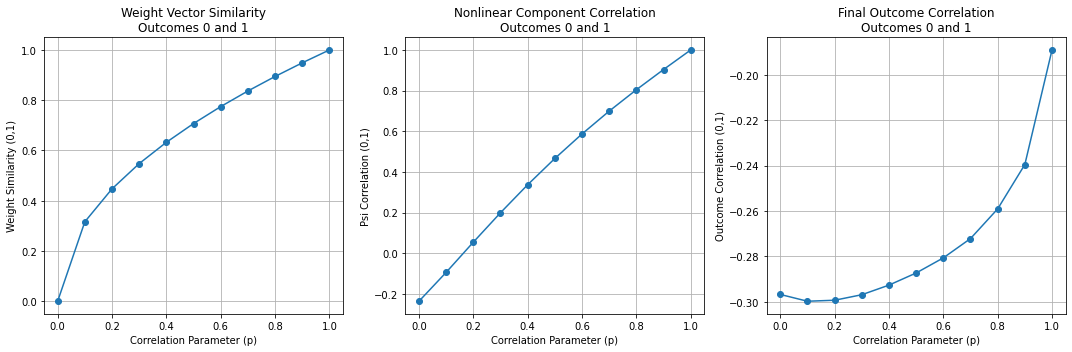


With 3 outcomes:


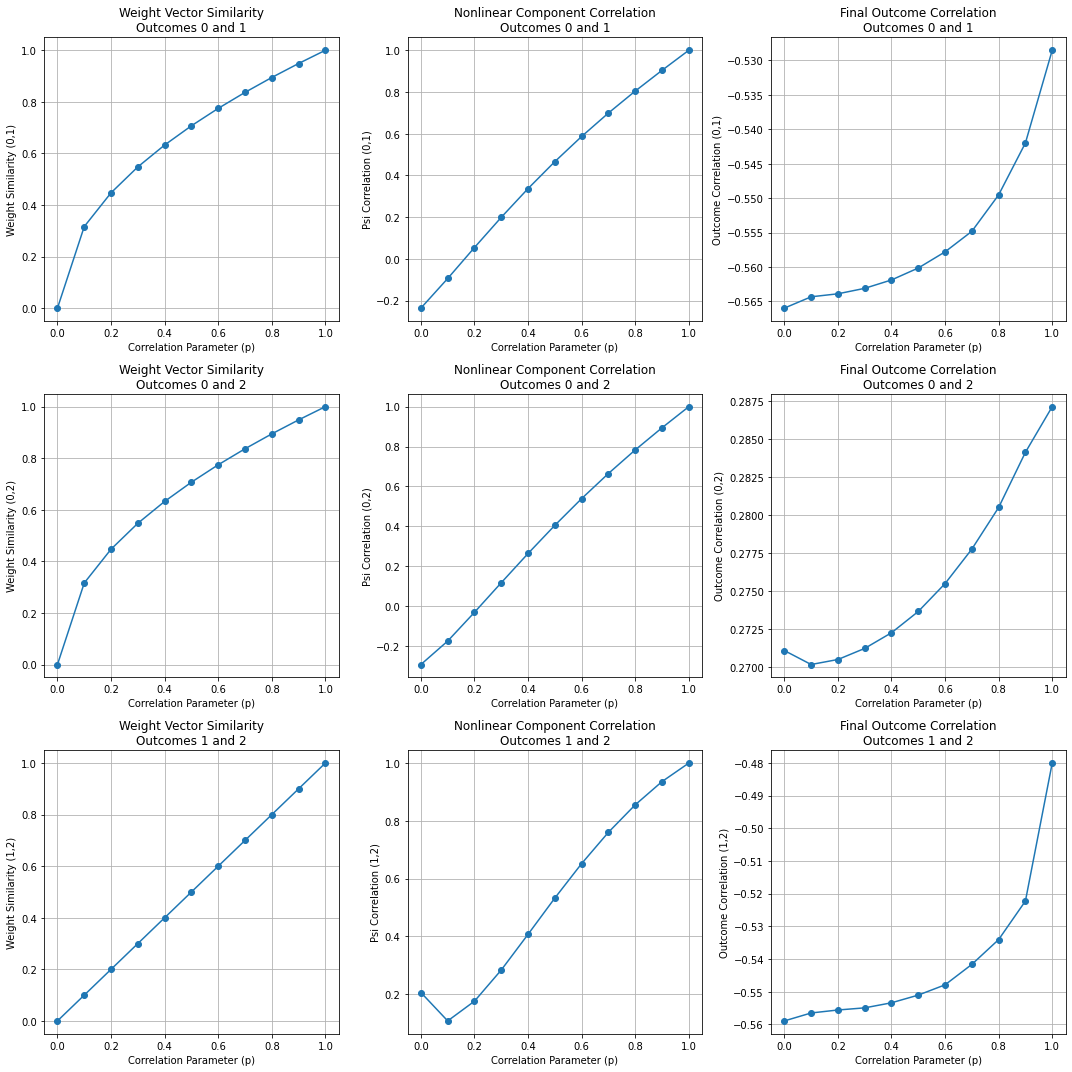

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

############################
# 1. Data Generation Components
############################

def softmax(x, axis=-1):
    """Compute softmax values for each set of scores in x."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class SmallMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out.squeeze(-1)

def generate_correlated_features(n_samples, n_features):
    """Generate features with complex correlation structure"""
    X = np.random.randn(n_samples, n_features)
    
    # First 5 features - strong correlations
    X[:, 1] = 0.7 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 2] = -0.5 * X[:, 1] + 0.2 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 3] = np.sin(X[:, 0]) + 0.2 * X[:, 1]**2 + 0.3 * np.random.randn(n_samples)
    X[:, 4] = X[:, 0] * X[:, 1] + np.exp(X[:, 2] * 0.3) + 0.3 * np.random.randn(n_samples)
    
    # Additional features (5-9) - weaker correlations
    if n_features > 5:
        X[:, 5] = 0.3 * X[:, 0] + 0.2 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 6] = np.cos(X[:, 1]) + 0.1 * X[:, 3] + 0.5 * np.random.randn(n_samples)
        X[:, 7] = 0.4 * X[:, 2] - 0.2 * X[:, 5] + 0.5 * np.random.randn(n_samples)
        X[:, 8] = np.sin(X[:, 6]) + 0.3 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 9] = 0.25 * X[:, 7] + 0.25 * X[:, 8] + 0.5 * np.random.randn(n_samples)
    
    # Normalize features
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X

def generate_data(
    N=10000, 
    d=10,
    num_treatments=3,
    num_outcomes=2,
    confounding_level=3.0,
    outcome_correlation=0.1,
    prognostic_strength=5.0,
    treatment_strength=0.5,
    seed=42
):
    """
    Generate synthetic data for causal inference with multiple treatments and outcomes.
    
    Parameters:
    -----------
    N : int
        Number of samples
    d : int
        Number of features
    num_treatments : int
        Number of treatment options
    num_outcomes : int
        Number of outcomes
    confounding_level : float
        Strength of confounding (0.0 = no confounding)
    outcome_correlation : float
        Correlation between outcomes (0.0 = independent, 1.0 = perfectly correlated)
    prognostic_strength : float
        Strength of direct effect of X on Y
    treatment_strength : float
        Strength of treatment effects
    seed : int
        Random seed for reproducibility
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Generate features with realistic correlation structure
    X = generate_correlated_features(N, d)
    
    # Treatment assignment with confounding
    beta_0 = np.random.normal(0, 0.1, size=num_treatments)
    beta_k = np.random.normal(0, 1.0, size=(num_treatments, d))
    
    alpha_list = []
    for k in range(num_treatments):
        alpha_k = beta_0[k] + confounding_level * X.dot(beta_k[k])
        alpha_list.append(alpha_k)
    alpha_np = np.vstack(alpha_list).T
    propensity = softmax(alpha_np, axis=1)
    T = np.array([np.random.choice(num_treatments, p=p) for p in propensity])
    T_ind = np.zeros((N, num_treatments))
    T_ind[np.arange(N), T] = 1
    
    # Generate orthonormal basis vectors for outcome correlation
    basis_vectors = []
    v1 = np.random.normal(0, 1, size=5)
    v1 = v1 / np.linalg.norm(v1)
    basis_vectors.append(v1)
    
    for m in range(1, num_outcomes):
        v = np.random.normal(0, 1, size=5)
        for u in basis_vectors:
            v = v - (v @ u) * u
        v = v / np.linalg.norm(v)
        basis_vectors.append(v)
    
    # Generate outcomes
    Y = np.zeros((N, num_outcomes))
    true_cate = {f'outcome{m}': np.zeros((N, num_treatments-1)) for m in range(num_outcomes)}
    all_psi_values = np.zeros((N, num_outcomes))
    
    base_mlp = SmallMLP(input_dim=d)
    weights = np.zeros((num_outcomes, 5))
    
    for m in range(num_outcomes):
        # Generate correlated weights
        if m == 0:
            weights[m] = 2.0 * basis_vectors[0]
        else:
            weights[m] = 2.0 * (np.sqrt(1-outcome_correlation) * basis_vectors[m] + 
                               np.sqrt(outcome_correlation) * basis_vectors[0])
        
        # Generate parameters
        gamma_0 = np.random.normal(0, 0.1)
        gamma_m = np.random.normal(0, 0.5, size=d)
        delta_m = np.random.normal(0, 0.3, size=num_treatments)
        
        # Calculate baseline effects (stronger prognostic effect)
        x_5 = X[:, :5]
        w_effect = weights[m].dot(x_5.T)
        B_m = prognostic_strength * (
            gamma_0 + 
            X.dot(gamma_m) +
            0.5 * np.sin(2 * w_effect)
        )
        
        # Calculate treatment effects (relatively smaller)
        E_m = np.zeros(N)
        for t in range(num_treatments):
            base_effect = base_mlp(torch.FloatTensor(X)).detach().numpy()
            mlp = SmallMLP(input_dim=d)
            specific_effect = mlp(torch.FloatTensor(X)).detach().numpy()
            
            psi_mt = 0.3 * (
                np.sqrt(outcome_correlation) * base_effect +
                np.sqrt(1 - outcome_correlation) * specific_effect
            )
            
            if t == 0:
                all_psi_values[:, m] = psi_mt
            
            treatment_effect = treatment_strength * (
                delta_m[t] +  
                0.2 * X.dot(gamma_m) +  
                psi_mt +  
                0.1 * w_effect
            )
            
            E_m += T_ind[:, t] * treatment_effect
        
        Y[:, m] = B_m + E_m + 0.1 * np.random.randn(N)
        
        # Calculate true CATE
        for t in range(1, num_treatments):
            mlp_t = SmallMLP(input_dim=d)
            psi_t = 0.3 * mlp_t(torch.FloatTensor(X)).detach().numpy()
            mlp_0 = SmallMLP(input_dim=d)
            psi_0 = 0.3 * mlp_0(torch.FloatTensor(X)).detach().numpy()
            
            true_cate[f'outcome{m}'][:, t-1] = treatment_strength * (
                (delta_m[t] - delta_m[0]) +
                0.2 * X.dot(gamma_m) +
                (psi_t - psi_0) +
                0.1 * w_effect
            )
    
    return {
        'X': X,
        'T': T,
        'Y': Y,
        'true_cate': true_cate,
        'weights': weights,
        'psi_vals': all_psi_values
    }

def analyze_component_correlations(M=2, N=3000):
    """Analyze correlations between different components of the outcomes."""
    p_values = np.linspace(0, 1, 11)
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    
    results = {(i,j): {
        'weight_sims': [], 
        'psi_corrs': [], 
        'outcome_corrs': []
    } for i,j in outcome_pairs}
    
    for p in p_values:
        data = generate_data(N=N, outcome_correlation=p, num_outcomes=M)
        
        for i, j in outcome_pairs:
            # Weight vector similarity
            w_i, w_j = data['weights'][i], data['weights'][j]
            weight_sim = w_i.dot(w_j) / (np.linalg.norm(w_i) * np.linalg.norm(w_j))
            
            # Nonlinear component correlation
            psi_corr = np.corrcoef(data['psi_vals'][:,i], data['psi_vals'][:,j])[0,1]
            
            # Final outcome correlation
            outcome_corr = np.corrcoef(data['Y'][:,i], data['Y'][:,j])[0,1]
            
            results[(i,j)]['weight_sims'].append(weight_sim)
            results[(i,j)]['psi_corrs'].append(psi_corr)
            results[(i,j)]['outcome_corrs'].append(outcome_corr)
    
    return results, p_values

def plot_component_correlations(results, p_values):
    """
    Plot correlations between different components of the outcomes.
    
    Parameters:
    -----------
    results : dict
        Results from analyze_component_correlations
    p_values : array
        Array of correlation parameters used
    """
    outcome_pairs = list(results.keys())
    plt.figure(figsize=(15, 5*len(outcome_pairs)))
    
    for idx, (i,j) in enumerate(outcome_pairs):
        # Weight similarities
        plt.subplot(len(outcome_pairs), 3, 3*idx + 1)
        plt.plot(p_values, results[(i,j)]['weight_sims'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Weight Similarity ({i},{j})')
        plt.title(f'Weight Vector Similarity\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Nonlinear correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 2)
        plt.plot(p_values, results[(i,j)]['psi_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Psi Correlation ({i},{j})')
        plt.title(f'Nonlinear Component Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Outcome correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 3)
        plt.plot(p_values, results[(i,j)]['outcome_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Outcome Correlation ({i},{j})')
        plt.title(f'Final Outcome Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def experiment_correlation_vs_cosine(M=2):
    """
    Experiment to analyze relationship between outcome correlation and weight vector similarity.
    
    Parameters:
    -----------
    M : int
        Number of outcomes to analyze
    """
    results, p_values = analyze_component_correlations(M=M, N=3000)
    plot_component_correlations(results, p_values)

if __name__ == "__main__":
    # Example usage with different scenarios
    
    # Scenario 1: Strong confounding, strong prognostic effects, weak treatment effects
    print("Generating data with strong confounding and prognostic effects...")
    data = generate_data(
        N=1000,
        confounding_level=5.0,      # Strong confounding
        prognostic_strength=10.0,   # Strong prognostic effects
        treatment_strength=0.2      # Weak treatment effects
    )
    
    # Scenario 2: Analyze correlation structure
    print("\nAnalyzing correlation structure...")
    print("With 2 outcomes:")
    experiment_correlation_vs_cosine(M=2)
    
    print("\nWith 3 outcomes:")
    experiment_correlation_vs_cosine(M=3)


Generating data with strong confounding and prognostic effects...

Analyzing correlation structure...
With 2 outcomes:


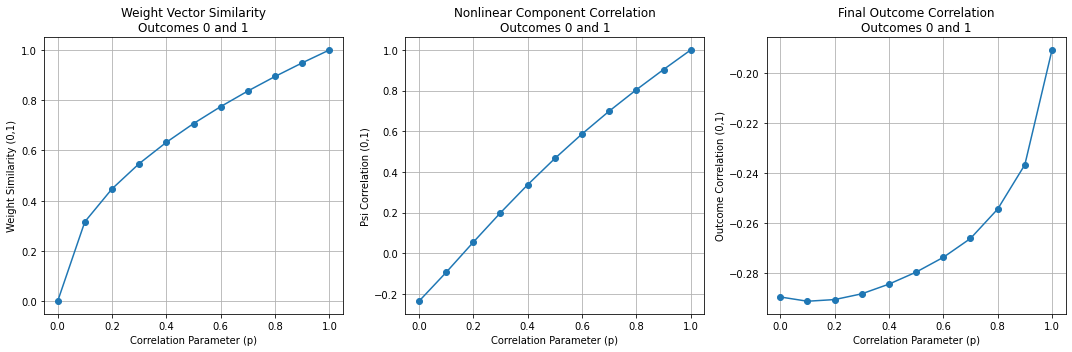


With 3 outcomes:


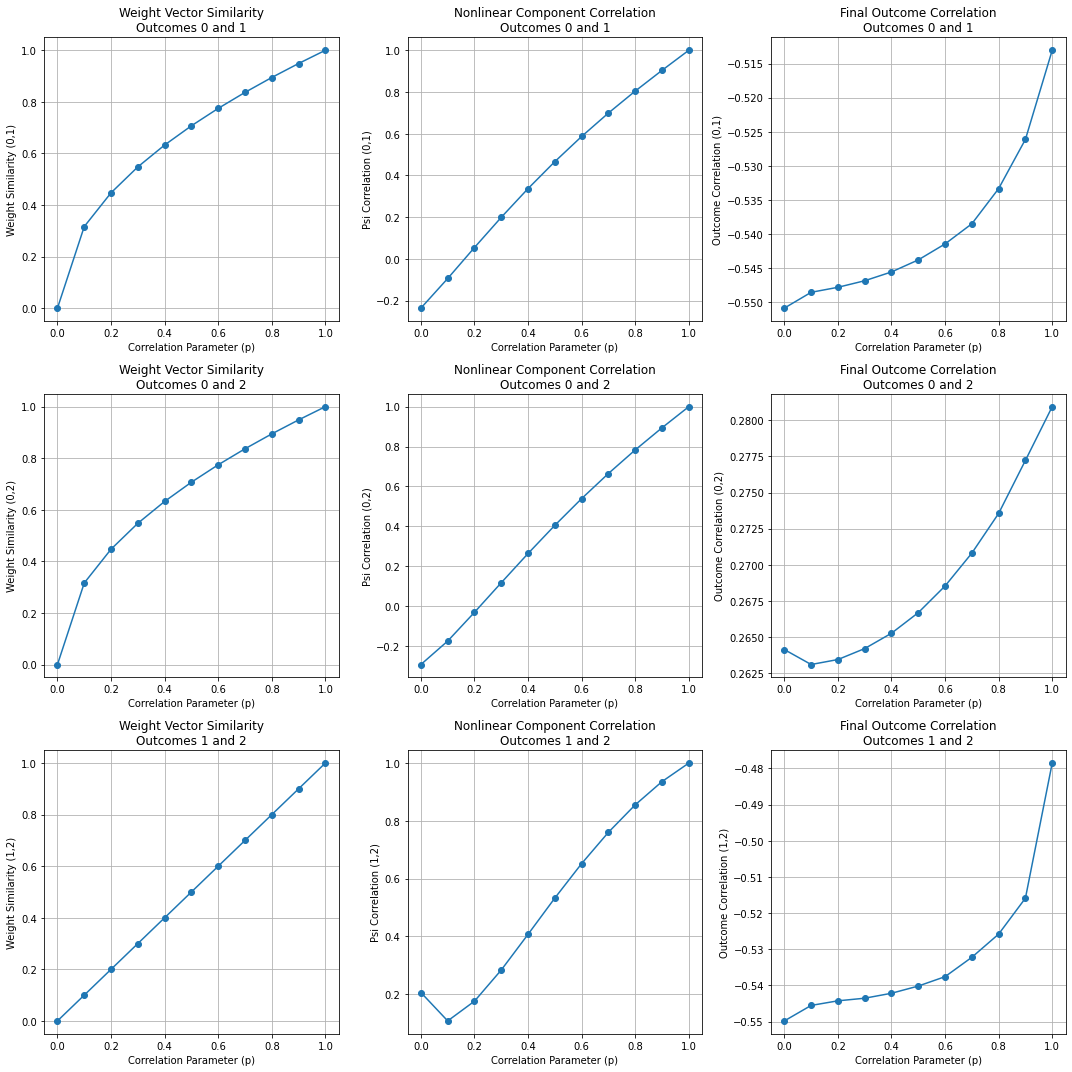

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

############################
# 1. Data Generation Components
############################

def softmax(x, axis=-1):
    """Compute softmax values for each set of scores in x."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class SmallMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out.squeeze(-1)

def generate_correlated_features(n_samples, n_features):
    """Generate features with complex correlation structure"""
    X = np.random.randn(n_samples, n_features)
    
    # First 5 features - strong correlations
    X[:, 1] = 0.7 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 2] = -0.5 * X[:, 1] + 0.2 * X[:, 0] + 0.3 * np.random.randn(n_samples)
    X[:, 3] = np.sin(X[:, 0]) + 0.2 * X[:, 1]**2 + 0.3 * np.random.randn(n_samples)
    X[:, 4] = X[:, 0] * X[:, 1] + np.exp(X[:, 2] * 0.3) + 0.3 * np.random.randn(n_samples)
    
    # Additional features (5-9) - weaker correlations
    if n_features > 5:
        X[:, 5] = 0.3 * X[:, 0] + 0.2 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 6] = np.cos(X[:, 1]) + 0.1 * X[:, 3] + 0.5 * np.random.randn(n_samples)
        X[:, 7] = 0.4 * X[:, 2] - 0.2 * X[:, 5] + 0.5 * np.random.randn(n_samples)
        X[:, 8] = np.sin(X[:, 6]) + 0.3 * X[:, 4] + 0.5 * np.random.randn(n_samples)
        X[:, 9] = 0.25 * X[:, 7] + 0.25 * X[:, 8] + 0.5 * np.random.randn(n_samples)
    
    # Normalize features
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X

def generate_data(
    N=10000, 
    d=10,
    num_treatments=3,
    num_outcomes=2,
    confounding_level=5.0,
    outcome_correlation=0.5,
    prognostic_strength=2.0,
    treatment_strength=0.5,
    seed=42
):
    """
    Generate synthetic data for causal inference with multiple treatments and outcomes.
    
    Parameters:
    -----------
    N : int
        Number of samples
    d : int
        Number of features
    num_treatments : int
        Number of treatment options
    num_outcomes : int
        Number of outcomes
    confounding_level : float
        Strength of confounding (0.0 = no confounding)
    outcome_correlation : float
        Correlation between outcomes (0.0 = independent, 1.0 = perfectly correlated)
    prognostic_strength : float
        Strength of direct effect of X on Y
    treatment_strength : float
        Strength of treatment effects
    seed : int
        Random seed for reproducibility
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Generate features with realistic correlation structure
    X = generate_correlated_features(N, d)
    
    # Treatment assignment with confounding
    beta_0 = np.random.normal(0, 0.1, size=num_treatments)
    beta_k = np.random.normal(0, 1.0, size=(num_treatments, d))
    
    alpha_list = []
    for k in range(num_treatments):
        alpha_k = beta_0[k] + confounding_level * X.dot(beta_k[k])
        alpha_list.append(alpha_k)
    alpha_np = np.vstack(alpha_list).T
    propensity = softmax(alpha_np, axis=1)
    T = np.array([np.random.choice(num_treatments, p=p) for p in propensity])
    T_ind = np.zeros((N, num_treatments))
    T_ind[np.arange(N), T] = 1
    
    # Generate orthonormal basis vectors for outcome correlation
    basis_vectors = []
    v1 = np.random.normal(0, 1, size=5)
    v1 = v1 / np.linalg.norm(v1)
    basis_vectors.append(v1)
    
    for m in range(1, num_outcomes):
        v = np.random.normal(0, 1, size=5)
        for u in basis_vectors:
            v = v - (v @ u) * u
        v = v / np.linalg.norm(v)
        basis_vectors.append(v)
    
    # Generate outcomes
    Y = np.zeros((N, num_outcomes))
    true_cate = {f'outcome{m}': np.zeros((N, num_treatments-1)) for m in range(num_outcomes)}
    all_psi_values = np.zeros((N, num_outcomes))
    
    base_mlp = SmallMLP(input_dim=d)
    weights = np.zeros((num_outcomes, 5))
    
    for m in range(num_outcomes):
        # Generate correlated weights
        if m == 0:
            weights[m] = 2.0 * basis_vectors[0]
        else:
            weights[m] = 2.0 * (np.sqrt(1-outcome_correlation) * basis_vectors[m] + 
                               np.sqrt(outcome_correlation) * basis_vectors[0])
        
        # Generate parameters
        gamma_0 = np.random.normal(0, 0.1)
        gamma_m = np.random.normal(0, 0.5, size=d)
        delta_m = np.random.normal(0, 0.3, size=num_treatments)
        
        # Calculate baseline effects (stronger prognostic effect)
        x_5 = X[:, :5]
        w_effect = weights[m].dot(x_5.T)
        B_m = prognostic_strength * (
            gamma_0 + 
            X.dot(gamma_m) +
            0.5 * np.sin(2 * w_effect)
        )
        
        # Calculate treatment effects (relatively smaller)
        E_m = np.zeros(N)
        for t in range(num_treatments):
            base_effect = base_mlp(torch.FloatTensor(X)).detach().numpy()
            mlp = SmallMLP(input_dim=d)
            specific_effect = mlp(torch.FloatTensor(X)).detach().numpy()
            
            psi_mt = 0.3 * (
                np.sqrt(outcome_correlation) * base_effect +
                np.sqrt(1 - outcome_correlation) * specific_effect
            )
            
            if t == 0:
                all_psi_values[:, m] = psi_mt
            
            treatment_effect = treatment_strength * (
                delta_m[t] +  
                0.2 * X.dot(gamma_m) +  
                psi_mt +  
                0.1 * w_effect
            )
            
            E_m += T_ind[:, t] * treatment_effect
        
        Y[:, m] = B_m + E_m + 0.1 * np.random.randn(N)
        
        # Calculate true CATE
        for t in range(1, num_treatments):
            mlp_t = SmallMLP(input_dim=d)
            psi_t = 0.3 * mlp_t(torch.FloatTensor(X)).detach().numpy()
            mlp_0 = SmallMLP(input_dim=d)
            psi_0 = 0.3 * mlp_0(torch.FloatTensor(X)).detach().numpy()
            
            true_cate[f'outcome{m}'][:, t-1] = treatment_strength * (
                (delta_m[t] - delta_m[0]) +
                0.2 * X.dot(gamma_m) +
                (psi_t - psi_0) +
                0.1 * w_effect
            )
    
    return {
        'X': X,
        'T': T,
        'Y': Y,
        'true_cate': true_cate,
        'weights': weights,
        'psi_vals': all_psi_values
    }

def analyze_component_correlations(M=2, N=3000):
    """Analyze correlations between different components of the outcomes."""
    p_values = np.linspace(0, 1, 11)
    outcome_pairs = [(i,j) for i in range(M) for j in range(i+1,M)]
    
    results = {(i,j): {
        'weight_sims': [], 
        'psi_corrs': [], 
        'outcome_corrs': []
    } for i,j in outcome_pairs}
    
    for p in p_values:
        data = generate_data(N=N, outcome_correlation=p, num_outcomes=M)
        
        for i, j in outcome_pairs:
            # Weight vector similarity
            w_i, w_j = data['weights'][i], data['weights'][j]
            weight_sim = w_i.dot(w_j) / (np.linalg.norm(w_i) * np.linalg.norm(w_j))
            
            # Nonlinear component correlation
            psi_corr = np.corrcoef(data['psi_vals'][:,i], data['psi_vals'][:,j])[0,1]
            
            # Final outcome correlation
            outcome_corr = np.corrcoef(data['Y'][:,i], data['Y'][:,j])[0,1]
            
            results[(i,j)]['weight_sims'].append(weight_sim)
            results[(i,j)]['psi_corrs'].append(psi_corr)
            results[(i,j)]['outcome_corrs'].append(outcome_corr)
    
    return results, p_values

def plot_component_correlations(results, p_values):
    """
    Plot correlations between different components of the outcomes.
    
    Parameters:
    -----------
    results : dict
        Results from analyze_component_correlations
    p_values : array
        Array of correlation parameters used
    """
    outcome_pairs = list(results.keys())
    plt.figure(figsize=(15, 5*len(outcome_pairs)))
    
    for idx, (i,j) in enumerate(outcome_pairs):
        # Weight similarities
        plt.subplot(len(outcome_pairs), 3, 3*idx + 1)
        plt.plot(p_values, results[(i,j)]['weight_sims'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Weight Similarity ({i},{j})')
        plt.title(f'Weight Vector Similarity\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Nonlinear correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 2)
        plt.plot(p_values, results[(i,j)]['psi_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Psi Correlation ({i},{j})')
        plt.title(f'Nonlinear Component Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
        
        # Outcome correlations
        plt.subplot(len(outcome_pairs), 3, 3*idx + 3)
        plt.plot(p_values, results[(i,j)]['outcome_corrs'], 'o-')
        plt.xlabel('Correlation Parameter (p)')
        plt.ylabel(f'Outcome Correlation ({i},{j})')
        plt.title(f'Final Outcome Correlation\nOutcomes {i} and {j}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def experiment_correlation_vs_cosine(M=2):
    """
    Experiment to analyze relationship between outcome correlation and weight vector similarity.
    
    Parameters:
    -----------
    M : int
        Number of outcomes to analyze
    """
    results, p_values = analyze_component_correlations(M=M, N=3000)
    plot_component_correlations(results, p_values)

def generate_all_scenarios(N=10000, d=10, num_outcomes=3, num_treatments=3,
                         confounding_level=6.0, outcome_correlation=0.5, base_seed=42):
    """Generate data for all six scenarios."""
    scenarios = {}
    
    # Define parameter modifications for each scenario
    scenario_params = {
        'A': dict(num_treatments=2, confounding_level=0.0),  # Binary T, Multiple O, No Conf
        'B': dict(num_outcomes=1, confounding_level=0.0),    # Multiple T, Single O, No Conf
        'C': dict(num_treatments=2),                         # Binary T, Multiple O, With Conf
        'D': dict(num_outcomes=1),                          # Multiple T, Single O, With Conf
        'E': dict(confounding_level=0.0),                   # Multiple T, Multiple O, No Conf
        'F': dict()                                         # Multiple T, Multiple O, With Conf
    }
    
    # Generate data for each scenario
    base_params = {
        'N': N,
        'd': d,
        'num_treatments': num_treatments,
        'num_outcomes': num_outcomes,
        'confounding_level': confounding_level,
        'outcome_correlation': outcome_correlation,
        'prognostic_strength': 2.0,    # Added with default value
        'treatment_strength': 0.5      # Added with default value
    }
    
    for scenario, override_params in scenario_params.items():
        # Create scenario-specific parameters by updating base parameters
        scenario_params = base_params.copy()
        scenario_params.update(override_params)
        scenario_params['seed'] = base_seed + ord(scenario) - ord('A')
        
        scenarios[scenario] = generate_data(**scenario_params)
    
    return scenarios

if __name__ == "__main__":
    # Example usage with different scenarios
    
    # Scenario 1: Strong confounding, strong prognostic effects, weak treatment effects
    print("Generating data with strong confounding and prognostic effects...")
    data = generate_data(
        N=1000,
        confounding_level=5.0,      # Strong confounding
        prognostic_strength=10.0,   # Strong prognostic effects
        treatment_strength=0.2      # Weak treatment effects
    )
    
    # Scenario 2: Analyze correlation structure
    print("\nAnalyzing correlation structure...")
    print("With 2 outcomes:")
    experiment_correlation_vs_cosine(M=2)
    
    print("\nWith 3 outcomes:")
    experiment_correlation_vs_cosine(M=3)
